# COVID-19 ABM Simulations

### Chirag Kumar - 20.09.2020

### This script develops and tests interventions for COVID-19 spread simulated using an ABM.
#### Strategies for the IOC for the Beijing Winter 2022 Olympics

## Prep Workspace

### Import and Set-up Packages: Python and R

In [1]:
# python packages
import pandas as pd # for dataframes
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for matplotlib settings
import os # for directories
#import rpy2 # for running r commands - namely plotting
from scipy.optimize import minimize # for optimization of noisy functions
from sodapy import Socrata # for quering CDC data
#from ddf_utils.factory.ihme import IHMELoader # for quering GHDx data
import scipy as sp # useful to have the whole library to access
from scipy import stats # for statistics and distributions
from scipy import integrate # for numerical integration processes
from scipy import signal # for finding peaks in data
from scipy import optimize # for optimizing functions
from sklearn.linear_model import LinearRegression # for easy linear regression
#import statsmodels.formula.api as smf # for GLMs
import statsmodels.api as sm
from tqdm.auto import tqdm # for progress bars
from tqdm.contrib.concurrent import process_map # for multiprocessing with progress bars
import pickle # for serializing objects
import datetime # for time series data
#import pathos # for multiprocessing
#import multiprocess # for multiprocessing
#import multiprocessing
#import numba # for fast compiling
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid, MultiGrid
from mesa.datacollection import DataCollector
#from mesa.visualization.modules import CanvasGrid
#from mesa.visualization.ModularVisualization import ModularServer
#from mesa.batchrunner import BatchRunner
#from mesa.batchrunner import BatchRunnerMP

In [2]:
# configure plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]
font = {'family' : 'Nimbus Roman',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)

### Define Directories

In [3]:
# define directories

# this is a hack to be able to refer to relative locations
if '__file__' not in globals():
    __file__ = '.'

inp_dir = os.path.abspath(os.path.dirname(__file__))
data_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                        'Data'))
out_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                       'Result Files'))
fig_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                          'Figures'))

### Get Data

#### COVID Cases (US) by Age and Gender - CDC

In [4]:
# set up client to get covid related data from cdc website
client_cdc = Socrata("data.cdc.gov",
                     "jvzE0iypgHmNoGyLoXS87pl9q") # this string is my app token

In [5]:
covid_cases_ag = pd.DataFrame.from_records(client_cdc.get("vbim-akqf", limit = 100000000))

In [6]:
max_date = pd.to_datetime(covid_cases_ag.cdc_report_dt).max()

In [7]:
max_date

Timestamp('2021-09-27 00:00:00')

In [8]:
covid_cases_ag = covid_cases_ag.drop(['cdc_report_dt', 'current_status', 'death_yn', 'hosp_yn', 'icu_yn',
                                     'medcond_yn', 'onset_dt', 'pos_spec_dt', 'race_ethnicity_combined'], axis = 1)

In [9]:
covid_cases_ag = covid_cases_ag.loc[np.logical_and(np.logical_not(np.logical_or(covid_cases_ag.age_group.str.contains('Unknown',
                                                                                                       regex = False),
                                                                covid_cases_ag.age_group.str.contains('NA',
                                                                                                      regex = False))),
                                                  np.logical_or(covid_cases_ag.sex.str.contains('Female',
                                                                                                regex = False),
                                                                covid_cases_ag.sex.str.contains('Male',
                                                                                               regex = False))), :]

covid_cases_ag['count'] = 1

In [10]:
covid_cases_ag = covid_cases_ag[covid_cases_ag.age_group != 'Missing']

In [11]:
covid_cases_ag = covid_cases_ag.drop('cdc_case_earliest_dt', axis = 1)

In [12]:
tt1 = covid_cases_ag.groupby(['age_group', 'sex']).count()
tt1 = pd.DataFrame(tt1.values.reshape((9, 2)))

In [13]:
tt1

,0,1
0,867963,912810
1,1978619,1877685
2,3188772,2839573
3,2797550,2545374
4,2470124,2239841
5,2307221,2162316
6,1601105,1524514
7,880421,809943
8,698279,440454


In [14]:
tt1.index = ['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years',
             '60 - 69 Years', '70 - 79 Years', '80+ Years']

tt1.columns = ['Female', 'Male']

In [15]:
covid_cases_age_gender = tt1.copy(deep = True)

In [16]:
# export the data
covid_cases_age_gender.to_csv(os.path.join(data_dir, 'COVID-Cases_Age-Gender.csv'), index = False)

In [17]:
covid_cases_age_gender = pd.read_csv(os.path.join(data_dir, 'COVID-Cases_Age-Gender.csv'))

In [18]:
covid_cases_age_gender.index = ['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years', '40 - 49 Years', '50 - 59 Years',
             '60 - 69 Years', '70 - 79 Years', '80+ Years']

In [19]:
covid_cases_age_gender

,Female,Male
0 - 9 Years,867963,912810
10 - 19 Years,1978619,1877685
20 - 29 Years,3188772,2839573
30 - 39 Years,2797550,2545374
40 - 49 Years,2470124,2239841
50 - 59 Years,2307221,2162316
60 - 69 Years,1601105,1524514
70 - 79 Years,880421,809943
80+ Years,698279,440454


#### COVID Deaths (US) by Age and Gender - CDC

In [20]:
# set up client to get covid related data from cdc website
client_cdc = Socrata("data.cdc.gov",
                     "jvzE0iypgHmNoGyLoXS87pl9q") # this string is my app token

In [21]:
# get the data from the cdc website
covid_deaths_ag = client_cdc.get("9bhg-hcku", limit = 10000000)

In [22]:
# turn it into a dataframe
covid_deaths_ag = pd.DataFrame.from_records(covid_deaths_ag)

In [23]:
covid_deaths_ag

,data_as_of,start_date,end_date,group,state,sex,age_group,covid_19_deaths,total_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid,footnote,year,month
0,2021-09-29T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,All Sexes,All Ages,687172,5732323,619182,347074,9325,967273,NaN,NaN,NaN
1,2021-09-29T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,All Sexes,Under 1 year,115,32488,353,14,22,476,NaN,NaN,NaN
2,2021-09-29T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,All Sexes,0-17 years,478,57466,985,115,188,1536,NaN,NaN,NaN
3,2021-09-29T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,All Sexes,1-4 years,59,6034,202,14,65,312,NaN,NaN,NaN
4,2021-09-29T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,All Sexes,5-14 years,154,9613,283,45,80,472,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66091,2021-09-29T00:00:00.000,2021-09-01T00:00:00.000,2021-09-25T00:00:00.000,By Month,Puerto Rico,Female,50-64 years,22,54,26,21,NaN,28,One or more data cells have counts between 1-9...,2021,9
66092,2021-09-29T00:00:00.000,2021-09-01T00:00:00.000,2021-09-25T00:00:00.000,By Month,Puerto Rico,Female,55-64 years,17,43,21,16,NaN,23,One or more data cells have counts between 1-9...,2021,9
66093,2021-09-29T00:00:00.000,2021-09-01T00:00:00.000,2021-09-25T00:00:00.000,By Month,Puerto Rico,Female,65-74 years,15,45,15,13,0,17,NaN,2021,9
66094,2021-09-29T00:00:00.000,2021-09-01T00:00:00.000,2021-09-25T00:00:00.000,By Month,Puerto Rico,Female,75-84 years,16,83,20,12,NaN,24,One or more data cells have counts between 1-9...,2021,9


In [24]:
# annoyingly, there are no standard age groups that all the data uses, so take a look at what age groups are
# used in this data set
covid_deaths_ag.age_group.value_counts()

30-39 years          3888
Under 1 year         3888
5-14 years           3888
All Ages             3888
85 years and over    3888
25-34 years          3888
40-49 years          3888
65-74 years          3888
1-4 years            3888
75-84 years          3888
50-64 years          3888
18-29 years          3888
15-24 years          3888
0-17 years           3888
35-44 years          3888
45-54 years          3888
55-64 years          3888
Name: age_group, dtype: int64

In [25]:
# filter just the columns we want: sex, age, and number of deaths

covid_deaths_age_gender = covid_deaths_ag.loc[np.logical_and(covid_deaths_ag.state == 'United States',
                                                          np.logical_or(covid_deaths_ag.sex == 'Male',
                                                                        covid_deaths_ag.sex == 'Female')),
                                           ['sex',
                                            'age_group',
                                            'covid_19_deaths']].reset_index(drop = True)

In [26]:
# filter so that we have the age groups with the most resolution

tt1 = np.logical_and(np.logical_and(np.logical_and(np.logical_and(covid_deaths_age_gender.age_group != 'All Ages',
                              covid_deaths_age_gender.age_group != '0-17 years'),
               covid_deaths_age_gender.age_group != '18-29 years'),
               covid_deaths_age_gender.age_group != '30-49 years'),
                    covid_deaths_age_gender.age_group != '50-64 years')

covid_deaths_age_gender = covid_deaths_age_gender.loc[tt1, :]

In [27]:
# take a look at the data
covid_deaths_age_gender.head()

,sex,age_group,covid_19_deaths
1,Male,Under 1 year,62
3,Male,1-4 years,29
4,Male,5-14 years,86
5,Male,15-24 years,865
7,Male,25-34 years,3976


In [28]:
# check that we have the right age groups
covid_deaths_age_gender.age_group.value_counts()

25-34 years          48
35-44 years          48
45-54 years          48
5-14 years           48
15-24 years          48
1-4 years            48
75-84 years          48
85 years and over    48
Under 1 year         48
40-49 years          48
55-64 years          48
30-39 years          48
65-74 years          48
Name: age_group, dtype: int64

In [29]:
# however, this data is not on the same time scale as the cases data above (cases data lags)
# so take only the proportion of deaths preceeding the `max_date`
covid_deaths_time = pd.DataFrame.from_records(client_cdc.get("r8kw-7aab",
                                                   limit = 10000000))

In [30]:
covid_deaths_time = covid_deaths_time[covid_deaths_time.state == 'United States']

In [31]:
max_date

Timestamp('2021-09-27 00:00:00')

In [32]:
tt1 = covid_deaths_time[pd.to_datetime(covid_deaths_time.end_date) < max_date].covid_19_deaths.astype(np.float64).sum()
tt2 = covid_deaths_time.covid_19_deaths.astype(np.float64).sum()

In [33]:
deaths_fraction = tt1 / tt2

In [34]:
deaths_fraction = 1

In [35]:
covid_deaths_age_gender.covid_19_deaths = covid_deaths_age_gender.covid_19_deaths.astype(float)

In [36]:
covid_deaths_age_gender.covid_19_deaths *= deaths_fraction

In [37]:
# export the data
covid_deaths_age_gender.to_csv(os.path.join(data_dir, 'COVID-Deaths_Age-Gender.csv'), index = False)

In [38]:
covid_deaths_age_gender = pd.read_csv(os.path.join(data_dir, 'COVID-Deaths_Age-Gender.csv'))

#### COVID Deaths (US) by Comorbidities - CDC

In [39]:
# this is the same process as with the cases by age and gender data above
covid_deaths_cm = client_cdc.get("hk9y-quqm", limit = 1000000)

In [40]:
covid_deaths_cm = pd.DataFrame.from_records(covid_deaths_cm)

In [41]:
covid_deaths_cm.shape

(298080, 14)

In [42]:
covid_deaths_cm.head()

,data_as_of,start_date,end_date,group,state,condition_group,condition,icd10_codes,age_group,covid_19_deaths,number_of_mentions,flag,year,month
0,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,671,703,NaN,NaN,NaN
1,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,3098,3180,NaN,NaN,NaN
2,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,8011,8254,NaN,NaN,NaN
3,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,21380,22049,NaN,NaN,NaN
4,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,48881,50283,NaN,NaN,NaN


In [43]:
covid_deaths_cm.condition.unique()

array(['Influenza and pneumonia', 'Chronic lower respiratory diseases',
       'Adult respiratory distress syndrome', 'Respiratory failure',
       'Respiratory arrest', 'Other diseases of the respiratory system',
       'Hypertensive diseases', 'Ischemic heart disease',
       'Cardiac arrest', 'Cardiac arrhythmia', 'Heart failure',
       'Cerebrovascular diseases',
       'Other diseases of the circulatory system', 'Sepsis',
       'Malignant neoplasms', 'Diabetes', 'Obesity', 'Alzheimer disease',
       'Vascular and unspecified dementia', 'Renal failure',
       'Intentional and unintentional injury, poisoning, and other adverse events',
       'All other conditions and causes (residual)', 'COVID-19'],
      dtype=object)

In [44]:
covid_deaths_cm.age_group.value_counts()

55-64         29808
45-54         29808
75-84         29808
85+           29808
35-44         29808
All Ages      29808
Not stated    29808
0-24          29808
25-34         29808
65-74         29808
Name: age_group, dtype: int64

In [45]:
covid_deaths_cm

,data_as_of,start_date,end_date,group,state,condition_group,condition,icd10_codes,age_group,covid_19_deaths,number_of_mentions,flag,year,month
0,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,671,703,NaN,NaN,NaN
1,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,3098,3180,NaN,NaN,NaN
2,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,8011,8254,NaN,NaN,NaN
3,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,21380,22049,NaN,NaN,NaN
4,2021-09-26T00:00:00.000,2020-01-01T00:00:00.000,2021-09-25T00:00:00.000,By Total,United States,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,48881,50283,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298075,2021-09-26T00:00:00.000,2021-05-01T00:00:00.000,2021-05-31T00:00:00.000,By Month,Puerto Rico,COVID-19,COVID-19,U071,All Ages,184,184,NaN,2021,5
298076,2021-09-26T00:00:00.000,2021-06-01T00:00:00.000,2021-06-30T00:00:00.000,By Month,Puerto Rico,COVID-19,COVID-19,U071,All Ages,35,35,NaN,2021,6
298077,2021-09-26T00:00:00.000,2021-07-01T00:00:00.000,2021-07-31T00:00:00.000,By Month,Puerto Rico,COVID-19,COVID-19,U071,All Ages,29,29,NaN,2021,7
298078,2021-09-26T00:00:00.000,2021-08-01T00:00:00.000,2021-08-28T00:00:00.000,By Month,Puerto Rico,COVID-19,COVID-19,U071,All Ages,229,229,NaN,2021,8


In [46]:
covid_deaths_comorbidities = covid_deaths_cm.loc[covid_deaths_cm.state == 'United States', :]

In [47]:
covid_deaths_comorbidities = covid_deaths_comorbidities[['condition_group', 'condition', 'age_group', 'number_of_mentions']]

In [48]:
covid_deaths_comorbidities = covid_deaths_comorbidities.rename(columns = {'number_of_mentions':'number_covid19_deaths'})

In [49]:
tt1 = np.logical_and(covid_deaths_comorbidities.age_group != 'All ages',
                     covid_deaths_comorbidities.age_group != 'Not stated')

covid_deaths_comorbidities = covid_deaths_comorbidities.loc[tt1, :]

In [50]:
covid_deaths_comorbidities.head()

,condition_group,condition,age_group,number_covid19_deaths
0,Respiratory diseases,Influenza and pneumonia,0-24,703
1,Respiratory diseases,Influenza and pneumonia,25-34,3180
2,Respiratory diseases,Influenza and pneumonia,35-44,8254
3,Respiratory diseases,Influenza and pneumonia,45-54,22049
4,Respiratory diseases,Influenza and pneumonia,55-64,50283


In [51]:
covid_deaths_comorbidities.age_group.value_counts()

35-44       552
25-34       552
0-24        552
85+         552
55-64       552
75-84       552
65-74       552
45-54       552
All Ages    552
Name: age_group, dtype: int64

In [52]:
covid_deaths_comorbidities.condition.value_counts()

Diabetes                                                                     216
Renal failure                                                                216
Heart failure                                                                216
Hypertensive diseases                                                        216
Respiratory failure                                                          216
Chronic lower respiratory diseases                                           216
Intentional and unintentional injury, poisoning, and other adverse events    216
All other conditions and causes (residual)                                   216
COVID-19                                                                     216
Adult respiratory distress syndrome                                          216
Cerebrovascular diseases                                                     216
Other diseases of the circulatory system                                     216
Ischemic heart disease      

In [53]:
covid_deaths_comorbidities.number_covid19_deaths = covid_deaths_comorbidities.number_covid19_deaths.astype(float)

covid_deaths_comorbidities.number_covid19_deaths *= deaths_fraction

In [54]:
# export the data
covid_deaths_comorbidities.to_csv(os.path.join(data_dir, 'COVID-Deaths_Comorbidities.csv'), index = False)

In [55]:
covid_deaths_comorbidities = pd.read_csv(os.path.join(data_dir, 'COVID-Deaths_Comorbidities.csv'))

#### Data on Comorbidities Prevalence (US) - GHBx

In [56]:
# TO DO IN AN AUTOMATED FASHION...
#client_ihme = IHMELoader()

In [57]:
#client_ihme.bulk_download(out_dir = data_dir,
#                          version = [i for i in range(1000) if client_ihme.has_newer_source(i)][-1] + 1,
#                         context = ['le'], year = [2017])

In [58]:
# read the comorbidities data that ruchita gave me...
# these are prevalence values, not incidences
comorbidities_prevalence = pd.read_csv(os.path.join(data_dir,
                                                    'IHME-GBD_2017_DATA-66c072b7-1/IHME-GBD_2017_DATA-66c072b7-1-SpecificAgesOnly.csv'))

In [59]:
# take just the variable i need
comorbidities_prevalence = comorbidities_prevalence.loc[:, ['sex', 'age', 'cause', 'val']]

In [60]:
# take a look at the data
comorbidities_prevalence.head()

,sex,age,cause,val
0,Male,1 to 4,Chronic respiratory diseases,0.131947
1,Female,1 to 4,Chronic respiratory diseases,0.076593
2,Male,5 to 9,Chronic respiratory diseases,0.128654
3,Female,5 to 9,Chronic respiratory diseases,0.081235
4,Male,10 to 14,Chronic respiratory diseases,0.081274


In [61]:
# add obesity data from the cdc
#20–39 40–59 60 and over
#
#Men 40.3(3.8) 46.4(3.2) 42.2 (3.3)
#Women 39.7(2.7) 43.3 (2.7) 43.3 (3.0)

tt1 = comorbidities_prevalence.loc[comorbidities_prevalence.cause == 'Chronic respiratory diseases', :]
tt1.loc[:, 'cause'] = 'Obesity'

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '20 to 24',
                                                tt1.age == '25 to 29'),
                                  tt1.age == '30 to 34'),
                   tt1.age == '35 to 39')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .403
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .397

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '40 to 44',
                                                tt1.age == '45 to 49'),
                                  tt1.age == '50 to 54'),
                   tt1.age == '55 to 59')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .464
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .433

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .403
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .397

tt2 = np.logical_or(np.logical_or(np.logical_or(tt1.age == '60 to 64',
                                                tt1.age == '65 to 69'),
                                  tt1.age == '70 to 74'),
                   tt1.age == '75 to 79')

tt1.loc[np.logical_and(tt2, tt1.sex == 'Male'), 'val'] = .422
tt1.loc[np.logical_and(tt2, tt1.sex == 'Female'), 'val'] = .433

comorbidities_prevalence = pd.concat([comorbidities_prevalence,
                                     tt1], axis = 0)

/Genomics/grid/users/ckkumar/.conda/envs/research_defaults/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [62]:
# age resolution of the data
comorbidities_prevalence.age.value_counts()

45 to 49    14
60 to 64    14
35 to 39    14
30 to 34    14
1 to 4      14
40 to 44    14
55 to 59    14
80 to 84    14
85 to 89    14
5 to 9      14
20 to 24    14
90 to 94    14
50 to 54    14
10 to 14    14
25 to 29    14
65 to 69    14
75 to 79    14
70 to 74    14
95 plus     14
15 to 19    14
Name: age, dtype: int64

In [63]:
# what types of comorbidities do we have in the data?
comorbidities_prevalence.cause.value_counts()

Chronic respiratory diseases               40
Obesity                                    40
Alzheimer's disease and other dementias    40
Respiratory infections and tuberculosis    40
Neoplasms                                  40
Diabetes and kidney diseases               40
Cardiovascular diseases                    40
Name: cause, dtype: int64

#### Testing Effectiveness

In [64]:
# turn them into a nice dataframe
testing_effectiveness = pd.DataFrame(columns = ['sensitivity',
                                                'specificity'], index = ['rt-pcr',
                                                                         'antibody',
                                                                        'antigen'])
# recall sensitivity is true positives / (true pos + false negs)
# recall specificity is true negatives / (true negs + false positive)
testing_effectiveness.loc['rt-pcr', 'sensitivity'] = 1 # it's 1 because of the constraints for testing positive discussed below
testing_effectiveness.loc['rt-pcr', 'specificity'] = .99 # https://www.cell.com/med/pdf/S2666-6340(20)30016-7.pdf
# https://onlinelibrary.wiley.com/doi/pdf/10.1002/jmv.26211?casa_token=o2avJ_hHuagAAAAA%3ApBIZmAW7hn4vwT4rO5xWKP2CqjGo34TkkcVQ_EZ1_JtmLG_p_A4KLOlUvcOtekHDSvGUMIbUVTxrKAFO
testing_effectiveness.loc['antibody', 'sensitivity'] = .96
testing_effectiveness.loc['antibody', 'specificity'] = 0.95
# Comparison of automated SARS-CoV-2 antigen test for COVID-19 infection with quantitative RT-PCR using 313 nasopharyngeal
# swabs, including from seven serially followed patients
testing_effectiveness.loc['antigen', 'sensitivity'] = [1, 0.93, 0.83, 0.215667]
# sensitivity for quantitative antigen test
# [1, 0.93, 0.83, 0.215667] # sensitivity for >1600, 400, 100, <100 viral loads from pdf sent by IOC
# for lateral flow antigen tests: [1/33, 11/82, 40/69, 52/59, 61/61]
# https://www.ox.ac.uk/sites/files/oxford/media_wysiwyg/UK%20evaluation_PHE%20Porton%20Down%20%20University%20of%20Oxford_final.pdf
testing_effectiveness.loc['antigen', 'specificity'] = 0.98

In [65]:
testing_effectiveness

,sensitivity,specificity
rt-pcr,1,0.99
antibody,0.96,0.95
antigen,"[1, 0.93, 0.83, 0.215667]",0.98


#### Probability of Transmission Over Time

In [66]:
bootstrapped_gamma_params = pd.read_csv(os.path.join(data_dir,
                                                     'InfectiousnessGamaDistributionBootstrappedParameters.csv'))
bootstrapped_gamma_params = bootstrapped_gamma_params.drop('Unnamed: 0', axis = 1)

In [67]:
bootstrapped_gamma_params.head()

,X1,X2,X3
0,17.696575,1.506983,12.151353
1,20.343921,2.325398,9.113862
2,17.183901,1.347468,12.744004
3,37.751425,2.583141,15.361128
4,17.216775,1.132562,14.605513


#### Viral Load Over Time

In [68]:
# units of log10 copies per mL
viral_load = pd.read_csv(os.path.join(data_dir,
                                      'ViralLoadDaysSinceSymptomOnsetMetaAnalysis-SpatialTemporalDynamics.csv'))
viral_load = viral_load.loc[np.logical_and(viral_load.Swab == 'URT',
                                          True), :]
viral_load = viral_load.drop(['Author'], axis = 1)

In [69]:
viral_load.head()

,Disease,Swab,Day,Viral_load_log10
0,Severe,URT,5.0,8.12
1,Severe,URT,6.0,7.94
2,Mild,URT,4.0,7.34
3,Mild,URT,2.0,7.29
4,Mild,URT,5.0,6.94


In [70]:
#tt1 = viral_load.copy(deep = True)

In [71]:
#tt1['infectiousness'] = [stats.gamma.pdf(x, 20.51651, -12.27248, 1/1.592124) for x in tt1.Day]

In [72]:
#tt1['infectiousness']

In [73]:
#plt.scatter(tt1['infectiousness'], tt1['Viral_load_log10'])

In [74]:
#plt.scatter(viral_load['Day'][viral_load['Day'] > 3], viral_load['Viral_load_log10'][viral_load['Day'] > 3])
#plt.grid()

In [75]:
viral_load_kinetics = sm.OLS(viral_load['Viral_load_log10'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3],
        np.vstack((np.ones(viral_load['Day'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3].values.shape),
                       viral_load['Day'][~np.isnan(viral_load['Viral_load_log10'])][viral_load['Day'] > 3].values)).T).fit()

In [76]:
viral_load_ct = LinearRegression().fit(np.array([0.91, 10.42]).reshape(-1, 1),
                                       np.array([37.92, 6.16]).reshape(-1, 1))

In [77]:
ct_viral_load = LinearRegression().fit(np.array([37.92, 6.16]).reshape(-1, 1),
                                       np.array([0.91, 10.42]).reshape(-1, 1))

#### Contacts Distribution

In [78]:
# number of contacts
k = 0.16 # Estimating the overdispersion in COVID-19 transmissionusing outbreak sizes outside China
m = 2.5
Xs = np.array(range(101))

p_contacts = (sp.special.gamma(k + Xs) / (sp.special.gamma(Xs + 1) * sp.special.gamma(k))) * (np.power(m / (m + k),
                                                                                                       Xs)) * ((1 + (m / k)) ** (-k))
#p_contacts = p_contacts[1:]

#### Duration and Length of Hospital Stay

In [79]:
# computed negative binomial parameters
duration_nbinom_parameters = pd.read_csv(os.path.join(data_dir, 'NegativeBinomialDistributionParameters.csv'))

In [80]:
duration_nbinom_parameters.index = ['critical_duration<=49',
                                   'death_hospital<=49',
                                   'critical_duration<=64',
                                   'death_hospital<=64',
                                   'critical_duration>64',
                                   'death_hospital>64',
                                   'duration_overall',
                                   'hospital<=49',
                                   'icu<=49',
                                   'hospital<=64',
                                   'icu<=64',
                                   'hospital>64',
                                   'icu>64']

In [81]:
duration_nbinom_parameters

,parameters
critical_duration<=49,[2.26301767 0.23720976]
death_hospital<=49,[3.25586607 0.14953476]
critical_duration<=64,[1.50981693 0.17303526]
death_hospital<=64,[2.99027446 0.13456361]
critical_duration>64,[1. 0.14]
death_hospital>64,[3.67138167 0.19844192]
duration_overall,[3.55275464 0.14080489]
hospital<=49,[3. 0.44]
icu<=49,[2.58187094 0.15131289]
hospital<=64,[3. 0.39]


### Contact Matrix

In [82]:
contact = pd.read_csv(os.path.join(data_dir, 'United_States_country_level_M_overall_contact_matrix_85.csv'),
                      header = None)

In [83]:
contact.index = [*[str(i) for i in range(84)], '84+']

In [84]:
contact.columns = [*[str(i) for i in range(84)], '84+']

In [85]:
contact

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84+
0,0.098925,0.134595,0.175228,0.164398,0.159223,0.152069,0.135447,0.115937,0.101819,0.094288,...,0.016081,0.014545,0.014170,0.013570,0.013607,0.012800,0.012372,0.011824,0.010691,0.056750
1,0.104989,0.136459,0.175462,0.164785,0.155246,0.149267,0.137756,0.124234,0.107569,0.098544,...,0.016616,0.014720,0.014603,0.013640,0.013933,0.012973,0.012353,0.011831,0.010708,0.056652
2,0.109113,0.140068,0.178301,0.162160,0.153089,0.148560,0.140170,0.128624,0.116938,0.104829,...,0.016384,0.014653,0.014569,0.013898,0.013745,0.013173,0.012284,0.011767,0.010588,0.056591
3,0.112355,0.144378,0.177980,1.174693,0.388566,0.633950,0.442196,0.465731,0.416911,0.398361,...,0.017339,0.014805,0.014832,0.013792,0.014027,0.013198,0.012333,0.011808,0.010676,0.056917
4,0.116339,0.145421,0.179636,0.415419,1.937041,0.526381,0.818317,0.745859,0.729147,0.715125,...,0.018097,0.015082,0.014821,0.013829,0.014056,0.013070,0.012233,0.011844,0.010753,0.056971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.029902,0.038855,0.049422,0.045115,0.041789,0.042325,0.041182,0.041372,0.042086,0.043442,...,0.112893,0.121647,0.146544,0.152366,0.175209,0.184784,0.162792,0.147072,0.124365,0.326191
81,0.030613,0.039183,0.048810,0.044649,0.041427,0.042167,0.041258,0.040965,0.042154,0.043602,...,0.087801,0.095372,0.122209,0.135292,0.161210,0.172414,0.182540,0.165399,0.145658,0.383086
82,0.030594,0.039245,0.048895,0.044705,0.041943,0.041942,0.041206,0.041302,0.041436,0.043082,...,0.073993,0.080463,0.101068,0.115329,0.149522,0.162888,0.172963,0.178159,0.155772,0.464515
83,0.030264,0.038859,0.048132,0.044220,0.041658,0.041537,0.040519,0.041253,0.041106,0.042868,...,0.060787,0.071296,0.087361,0.103368,0.125520,0.150687,0.166638,0.170416,0.157315,0.530451


## Process Data

In [86]:
# standardize the data from various sources so that it is all interchangeable
# recall that each dataset uses a different set of age groups
# i make dictionaries that map the age groups to specific ages for each dataset

# make a dictionary that links the age groups to ages

age_groups_overall_covid_cases = {'0 - 9 Years' : list(range(0, 10)),
                                  '10 - 19 Years' : list(range(10, 20)),
                                  '20 - 29 Years' : list(range(20, 30)),
                                  '30 - 39 Years' : list(range(30, 40)),
                                  '40 - 49 Years' : list(range(40, 50)),
                                  '50 - 59 Years' : list(range(50, 60)),
                                  '60 - 69 Years' : list(range(60, 70)),
                                  '70 - 79 Years' : list(range(70, 80)),
                                  '80+ Years' : list(range(80, 111))}

age_groups_overall_covid_deaths = {'65-74 years' : list(range(65, 75)),
                                  '85 years and over' : list(range(85, 111)),
                                  '55-64 years' : list(range(55, 65)),
                                  '35-44 years' : list(range(35, 45)),
                                  '75-84 years' : list(range(75, 85)),
                                  '25-34 years' : list(range(25, 35)),
                                  '15-24 years' : list(range(15, 25)),
                                  '1-4 years' : list(range(1, 5)),
                                  'Under 1 year' : list(range(0, 1)),
                                  '5-14 years' : list(range(5, 15)),
                                  '45-54 years' : list(range(45, 55))}


age_groups_comorbidities_covid_deaths = {'65-74' : list(range(65, 75)),
                                  '85+' : list(range(85, 111)),
                                  '55-64' : list(range(55, 65)),
                                  '35-44' : list(range(35, 45)),
                                  '75-84' : list(range(75, 85)),
                                  '25-34' : list(range(25, 35)),
                                  '0-24' : list(range(0, 25)),
                                  '45-54' : list(range(45, 55))}

age_groups_comorbidities = {'1 to 4' : list(range(0, 5)),
                            '5 to 9' : list(range(5, 10)),
                            '10 to 14' : list(range(10, 15)),
                            '15 to 19' : list(range(15, 20)),
                            '20 to 24' : list(range(20, 25)),
                            '25 to 29' : list(range(25, 30)),
                            '30 to 34' : list(range(30, 35)),
                            '35 to 39' : list(range(35, 40)),
                            '40 to 44' : list(range(40, 45)),
                            '45 to 49' : list(range(45, 50)),
                            '50 to 54' : list(range(50, 55)),
                            '55 to 59' : list(range(55, 60)),
                            '60 to 64' : list(range(60, 65)),
                            '65 to 69' : list(range(65, 70)),
                            '70 to 74' : list(range(70, 75)),
                            '75 to 79' : list(range(75, 80)),
                            '80 to 84' : list(range(80, 85)),
                            '85 to 89' : list(range(85, 90)),
                            '90 to 94' : list(range(90, 95)),
                            '95 plus' : list(range(95, 111))}

In [87]:
# Finally, make an comorbidities dictionary that maps the comorbidities in the covid deaths data to the
# comorbdities for which we have prevalence

### TO BE IMPROVED ONCE WE HAVE MORE DETAILED COMORBIDITIES DATA

comorbidities_aggregate = {'Chronic respiratory diseases' : ['Chronic lower respiratory diseases',
                                                           'Adult respiratory distress syndrome',
                                                           'Respiratory arrest',
                                                           'Other diseases of the respiratory system'],
                          'Cardiovascular diseases' : ['Hypertensive diseases',
                                                     'Ischemic heart disease',
                                                     'Cardiac arrhythmia',
                                                     'Cerebrovascular diseases',
                                                     'Other diseases of the circulatory system'],
                          'Respiratory infections and tuberculosis' : ['Sepsis'],
                          'Diabetes and kidney diseases' : ['Diabetes', 'Renal failure'],
                          'Neoplasms' : ['Malignant neoplasms'],
                           'Obesity' : ['Obesity'],
                           "Alzheimer's disease and other dementias" : ['Alzheimer disease',
                                                                        'Vascular and unspecified dementia'],
                           'Other conditions' : ['All other conditions and causes (residual)',
                                 'Influenza and pneumonia',
                                 'Respiratory failure',
                                 'Respiratory arrest',
                                 'Cardiac arrest',
                                 'Heart failure'],
                          None : ['COVID-19',
                                  'Intentional and unintentional injury, poisoning and other adverse events']}

In [88]:
athletes_country = pd.read_csv(os.path.join(data_dir, 'winter-olympics-delegation-distribution.csv'))

## Set Population Profile and COVID Testing Scenario

In [89]:
# set age and gender from IOC
age_gender_profile = pd.read_csv(os.path.join(data_dir, 'USCensus.csv')) # as template

In [90]:
age_gender_profile = age_gender_profile[1:]

In [91]:
age_gender_profile = age_gender_profile.iloc[18:40]

In [92]:
age_gender_profile

,Male,Female
19,"2,214,784","2,115,655"
20,"2,183,139","2,086,544"
21,"2,187,086","2,091,237"
22,"2,195,296","2,103,476"
23,"2,221,758","2,119,886"
24,"2,277,473","2,167,045"
25,"2,325,853","2,213,205"
26,"2,365,886","2,245,334"
27,"2,421,270","2,312,599"
28,"2,451,756","2,366,969"


In [93]:
age_gender_profile.iloc[:, :] = 1

In [94]:
class cost(object):    
    def __init__(self):
        self.running_total = 0.0
        self.false_positive = 0
        self.false_negative = 0
        self.improperly_quarantined_athletes = list()
        self.true_positives = 0
        
    # https://www.wsj.com/articles/covid-19-tests-answers-on-cost-accuracy-and-turnaround-time-11599134378
    def rt_pcr(self):
        self.running_total += 120.0
        
    def antigen(self):
        self.running_total += 5.0 # also kinda an estimate
        
    def quarantine(self):
        self.running_total += 0.0
        
    def antibody(self):
        self.running_total += 5.0 # really an estimate
        
    def icu(self):
        self.running_total += 0.0
        
    def hospital(self):
        self.running_total += 0.0
        
    def death(self):
        self.running_total += 0.0
        
    def improper_quarantine(self, agent):
        self.false_positive += 1
        self.improperly_quarantined_athletes.append(agent.unique_id)
    
    def improper_release(self):
        self.false_negative += 1
    
    def true_positive(self):
        self.true_positives += 1

In [95]:
class mitigation():
    """Various testing/quarantining/etc scenarios"""
    def __init__(self, testing_effectiveness, groups, period):
        self.groups = groups
        self.period = period
        self.testing_effectiveness = testing_effectiveness
        self.chunks = list(range(self.groups))
        self.testing = False
        self.current_chunk = self.chunks[0]
        self.cost = cost()
        
    # baseline scenario - no safety measures at all
    # trump strategy
    def baseline(self, agent, i):
        return None
    
    # randomly test people - small college strategy
    def rt_pcr_random(self, agent, N):
        # the people get tested once a cycle with each group getting tested
        if (N % self.period == 0 and agent.unique_id % self.groups == self.current_chunk): # and np.random.uniform(0, 1) < 0.25: # test this group of agents
            self.cost.rt_pcr()
            if agent.infection_course != None and np.random.uniform(low = 0.0,
                                                            high = 1.0,
                                                            size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'sensitivity']:
                current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
                # minimum level of detectability is about 0.91 log10 copies per mL from this paper:
                # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7235577/pdf/main.pdf
                
                if current_viral_load > 0.91:
                    return True
            if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'specificity']:
                return True
            else:
                return False
                    
            self.testing = True
            
        elif self.testing:
            self.testing = False
            self.current_chunk = self.chunks[(self.chunks.index(self.current_chunk) + 1) % len(self.chunks)]
        
    # test those who are symptomatic only
    def rt_pcr_symptom_expressing(self, agent, N):
        if agent.state == 'infected-s' or agent.state == 'hospitalized':
            self.cost.rt_pcr()
            
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
            
            if current_viral_load > 0.91 and np.random.uniform(low = 0.0, high = 1.0,
                                             size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                  'sensitivity']:
                return True
            if current_viral_load <= 0.91 and np.random.uniform(low = 0.0,
                                                                high = 1.0,
                                                                size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                  'specificity']:
                return True
            else:
                return False
            
    def rt_pcr(self, agent):
        self.cost.rt_pcr()
        if agent.infection_course != None and np.random.uniform(low = 0.0,
                                                            high = 1.0,
                                                            size = 1)[0] <= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'sensitivity']:
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
            # minimum level of detectability is about 0.91 log10 copies per mL from this paper:
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7235577/pdf/main.pdf
                
            if current_viral_load > 0.91:
                return True
        if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['rt-pcr',
                                                                                                          'specificity']:
            return True
        else:
            return False
            
    def antigen_random(self, agent, N):
        # the people get tested once a cycle with each group getting tested
        if (N % self.period == 0 and agent.unique_id % self.groups == self.current_chunk): # test this group of agents
            self.cost.antigen()
            if agent.infection_course != None:
                
                sensitivities = self.testing_effectiveness.loc['antigen', 'sensitivity']
                
                randn = np.random.uniform(low = 0.0, high = 1.0)
                
                current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
                if current_viral_load > np.log10(1600) and randn < sensitivities[0]:
                    self.cost.true_positive()
                    return True
                elif current_viral_load > np.log10(400) and randn < sensitivities[1]:
                    self.cost.true_positive()
                    return True
                elif current_viral_load > np.log10(100) and randn < sensitivities[2]:
                    self.cost.true_positive()
                    return True
                elif current_viral_load <= np.log10(100) and randn < sensitivities[3]:
                    self.cost.true_positive()
                    return True
                
#                 if current_viral_load < 3 and randn < sensitivities[0]:
#                     self.cost.true_positive()
#                     return True
#                 elif current_viral_load < 4 and randn < sensitivities[1]:
#                     self.cost.true_positive()
#                     return True
#                 elif current_viral_load < 5 and randn < sensitivities[2]:
#                     self.cost.true_positive()
#                     return True
#                 elif current_viral_load < 6 and randn < sensitivities[3]:
#                     self.cost.true_positive()
#                     return True
#                 elif current_viral_load > 7 and randn < sensitivities[4]:
#                     self.cost.true_positive()
#                     return True
                
                else:
                    self.cost.improper_release()
            if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['antigen',
                                                                                                          'specificity']:
                self.cost.improper_quarantine(agent)
                return True
            else:
                return False
                    
            self.testing = True
            
        elif self.testing:
            self.testing = False
            self.current_chunk = self.chunks[(self.chunks.index(self.current_chunk) + 1) % len(self.chunks)]
                
    # test those who are symptomatic only
    def antigen_symptom_expressing(self, agent, N):
        if agent.state == 'infected-s' or agent.state == 'hospitalized':
            self.cost.antigen()
            
            sensitivities = self.testing_effectiveness.loc['antigen', 'sensitivity']
                
            randn = np.random.uniform(low = 0.0, high = 1.0)
                
            current_viral_load = agent.infection_course['viral_load'][int(agent.infection_course['days_since_exposure'])]
                
            if current_viral_load < 3 and randn < sensitivities[0]:
                self.cost.true_positive()
                return True
            elif current_viral_load < 4 and randn < sensitivities[1]:
                self.cost.true_positive()
                return True
            elif current_viral_load < 5 and randn < sensitivities[2]:
                self.cost.true_positive()
                return True
            elif current_viral_load < 6 and randn < sensitivities[3]:
                self.cost.true_positive()
                return True
            elif current_viral_load > 7 and randn < sensitivities[4]:
                self.cost.true_positive()
                return True
        if agent.state != 'dead' and np.random.uniform(low = 0.0,
                                                             high = 1.0,
                                                             size = 1)[0] >= self.testing_effectiveness.loc['antigen',
                                                                                                          'specificity']:
            return True
        else:
            return False
                
    def antibody(self, agent):
        self.cost.antibody()
        if agent.state == 'recovered':
            if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] >= self.testing_effectiveness.loc['antibody',
                                                                                                  'sensitivity']:
                return False
            else:
                return True
        elif np.random.uniform(low = 0.0, high = 1.0) <= self.testing_effectiveness.loc['antibody',
                                                                                        'specificity']:
            return False
        else:
            return True

In [96]:
class scenario_details():
    """Holds the details required to specify the COVID transmission scenario explored"""
    
    def __init__(self,
                 comorbidities_distribution, prop_healthy, # population characteristics
                 spreader_prop,
                 cases_age_gender, risk_death_distribution, transmission_probability, # disease characteristics
                 mitigation_strategy, # testing scenario
                 external_connectivity, steps_per_day): # model parameters
        
        # define all the variables in this class as properties for easy access
        self.comorbidities_distribution = comorbidities_distribution # prob of each comorbidity by age,sex
        self.prop_healthy = prop_healthy
        self.spreader_prop = spreader_prop
        self.cases_age_gender = cases_age_gender # cases by age and gender
        self.risk_death_distribution = risk_death_distribution # risk of death for each age, sex, and comorbidity
        self.mitigation_strategy = mitigation_strategy # the testing scenario implemented in the current scenario
        self.external_connectivity = external_connectivity # prob that agents may get covid externally
        self.steps_per_day = steps_per_day # the chunks into which time is discretized
        
        # risk of death distribution is a tuple so break it up into its parts
        self.deaths_ag = risk_death_distribution[0]
        self.deaths_co = risk_death_distribution[1]
        
    # draw a random age from the age distribution
    def rnd_age(self):
        return np.random.choice(age_gender_profile.index,
                                p = age_gender_profile.sum(axis = 1) / age_gender_profile.sum(axis = 1).sum(axis = 0))
    
    # draw a random gender from the gender distribution
    def rnd_gender(self, age):
        gender_distribution = age_gender_profile.loc[age, :]
        if np.random.choice([0, 1], p = gender_distribution / gender_distribution.sum()) == 0:
            return 'Male'
        else:
            return 'Female'
    
    # based on age and gender, give the agent comorbidities
    def rnd_comorbidities(self, age, gender):
        # get risk of comorbidities based on age, gender
        # go from age number to an age range name in the comorbidities data
        age_range_name = [k for k, v in age_groups_comorbidities.items() if int(age) in v][0]
        
        # first let's give the people that are normal no comorbidities
        # data from Prevalence of Optimal Metabolic Health in American Adults:
        # National Health and Nutrition Examination Survey 2009–2016
        randn = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
        if age in range(40): # assume that people from age 0 to 20 have some metabolic health as age in 20-39
            if randn < 0.26 + self.prop_healthy[0]:
                return [None]
        elif age in range(40, 60):
            if randn < 0.105 + self.prop_healthy[1]:
                return [None]
        elif randn < 0.028 + self.prop_healthy[2]:
            return [None]
        
        # now let us allocate comorbidities to the remaining people - and treat them independently
        
        # take a subset of the comorbdity data for only this agent's gender and age
        tt1 = np.logical_and(self.comorbidities_distribution.sex == gender,
                             self.comorbidities_distribution.age == age_range_name)
        temp = self.comorbidities_distribution.loc[tt1, :].reset_index(drop = True)
        
        comorbidities_agent = []
        
        for comorbidity in temp.cause:
            randn = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
            if randn < temp.loc[temp.cause == comorbidity, 'val'].values[0]:
                comorbidities_agent.append(comorbidity)
                
        return comorbidities_agent if len(comorbidities_agent) != 0 else [np.random.choice(list(comorbidities_aggregate.keys()))]
        
    # based on age, gender, and comorbidities, determine the probability of death
    def risk_death(self, age, gender, comorbidities):
        # find overall chance of death given age and gender
        age_range_ = [k for k, v in age_groups_overall_covid_deaths.items() if int(age) in v][0]
        
        # subset just the part of the data that we are interested in 
        tt1 = np.logical_and(self.deaths_ag.sex == gender,
                             self.deaths_ag.age_group == age_range_)
        
        deaths_o = self.deaths_ag.loc[tt1, 'covid_19_deaths'].astype(int).values[0]
        
        # to convert to a probability, divide deaths by number of cases
        age_range_name_cases = [k for k, v in age_groups_overall_covid_cases.items() if int(age) in v][0]
        p_death_o = deaths_o / self.cases_age_gender[gender][age_range_name_cases]
        
        # however, this gives us the death for people of this age and gender - need to add in comorbidities
        # i don't have cases by comorbidities, so find how much specific comorbidities increase the probability
        # of death compared to other comorbidities
        
        age_range_name = [k for k, v in age_groups_comorbidities_covid_deaths.items() if int(age) in v][0]
        
        conditions = list(map(comorbidities_aggregate.get, comorbidities))
        
        tt1 = np.logical_and(self.deaths_co.condition.isin([condition[0] for condition in conditions]),
                             self.deaths_co.age_group == age_range_name)
        
        deaths_c = self.deaths_co.loc[tt1, 'number_covid19_deaths'].astype(int).values[0]
        
        deaths_all_c = self.deaths_co.loc[self.deaths_co.age_group == age_range_name,
                                                      'number_covid19_deaths'].astype(int).sum()
        
        risk_increase = deaths_c * len(self.deaths_co.condition.unique()) / deaths_all_c
        
        return p_death_o * risk_increase
    
    def spreader(self):
        if np.random.uniform(low = 0.0, high = 1.0) < self.spreader_prop:
            return True
        else:
            return False
    
    # create the course of the infection for the agent and store everything in a dictionary
    def infection_course(self, age, gender, comorbidities):
        # the infection course: incubation --> infectious-asy --? infectious-s --> R or D
        
        # first figure out for how long this agent will be in incubation
        # data from Incubation period of COVID-19: a rapid systematic review and meta-analysis of observational research
        # probability of symptom development is a lognormal with mu = 1.63 and sigma = 0.50
        incubation_days = round(stats.lognorm.rvs(s = 0.5, loc = 0, scale = np.exp(1.63), size = 1)[0])
        death = False
        # will this agent die?
        if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] <= self.risk_death(age,
                                                                                   gender,
                                                                                   comorbidities):
            death = True
            # now determine the duration of infection for this agent
            # for an agent that dies, assume that they go to the hospital first
            # at that point, they are no longer infectious
            # however, they may spend some time in the hospital before transitioning to dead
            
            # set a variable 'duration' for how long the individual is infectious - days until hospitalized
            # also set 'hospitalized_time' for how many days later the agent dies -- assume death in the hospital
            # https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html
            if age <= 49:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital<=49',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            elif age <= 64:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital<=64',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            else:
                duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                    :][0].split('   ')[1][:-1]))
                hospitalized_time = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['death_hospital>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['death_hospital>64',
                                                                                    :][0].split(' ')[1][:-1])) - duration
                
            hospitalized_time = hospitalized_time * (hospitalized_time > 0)
            duration = int(duration)
            hospitalized_time = int(hospitalized_time)
            
        else: # the agent can be asymptomatic wholly, symptomatic, and/or hospitalized with recovery
            
            # duration for this type of infection is relatively straightforward
            duration = stats.nbinom.rvs(loc = 0,
                                        n = float(duration_nbinom_parameters.loc['duration_overall',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['duration_overall',
                                                                                    :][0].split(' ')[1][:-1]))
            
            # determine whether agent if wholly asymptomatic
            
            # P(A) = 0.4 according to CDC website
            # want P(A | ~D) = P(~D | A) * P(A) / P(~D) = P(A) / P(~D)
            prob_asymptomatic = (.4 / (1 - self.risk_death(age, gender, comorbidities)))
            if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] < prob_asymptomatic:
                asymptomatic = True
            
            else:
                # this agent is symptomatic so is either midly symptomatic or severly symptomatic (hospitalized)
            
                # P(H | ~A) = P(~A | H) * P(H) / P(~A) = P(H) / P(~A)
                randn1 = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
                randn2 = np.random.uniform(low = 0.0, high = 1.0, size = 1)[0]
                
                if age <= 49:
                    # P(H) = P(D) / .024 which is value from CDC for proportion of cases hospitalized that die
                    # P(~A) = 1 - P(A)
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group').covid_19_deaths.iloc[0:7].sum()
                    p_H += .5 * covid_deaths_age_gender.sort_values(by = 'age_group').covid_19_deaths.iloc[8:10].sum()
                    p_H += covid_deaths_age_gender.sort_values(by = 'age_group').covid_19_deaths.iloc[10:12].sum()
                    p_H += covid_deaths_age_gender.sort_values(by = 'age_group').covid_19_deaths.iloc[20:].sum()
                    p_H /= covid_cases_age_gender.iloc[0:4, :].sum().sum()
                    p_H /= 0.024
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .238: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu<=49',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu<=49',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital<=49',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital<=49',
                                                                                    :][0].split('   ')[1][:-1]))
                    
                elif age <= 64:
                    
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group').covid_19_deaths.iloc[[12, 13]].sum()
                    p_H += .5 * covid_deaths_age_gender.sort_values(by = 'age_group').covid_19_deaths.iloc[8:10].sum()
                    p_H /= (covid_cases_age_gender.iloc[5, :].sum() + (.5 * covid_cases_age_gender.iloc[6, :].sum()))
                    p_H /= 0.1
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .353: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu<=64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu<=64',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital<=64',
                                                                                             :][0].split('   ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital<=64',
                                                                                    :][0].split('   ')[1][:-1]))
                    
                else:
                    
                    p_H = covid_deaths_age_gender.sort_values(by = 'age_group').covid_19_deaths.iloc[[14, 15, 16, 17, 18, 19]].sum()
                    p_H /= (covid_cases_age_gender.iloc[[7, 8], :].sum().sum() + (.5 * covid_cases_age_gender.iloc[6, :].sum()))
                    p_H /= 0.266
                    if randn1 < p_H / prob_asymptomatic:
                        
                        duration = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                             :][0].split('  ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['critical_duration>64',
                                                                                    :][0].split('  ')[1][:-1]))
                        
                        # given that this agent is hospitalized, are they put in the ICU?
                        # this matters because the duration of time is different in each unit
                    
                        if randn2 < .361: # value from CDC website
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['icu>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['icu>64',
                                                                                    :][0].split(' ')[1][:-1]))
                        else:
                            hospitalized_time = stats.nbinom.rvs(loc = 0,
                                                    n = float(duration_nbinom_parameters.loc['hospital>64',
                                                                                             :][0].split(' ')[0][1:]),
                                           p = float(duration_nbinom_parameters.loc['hospital>64',
                                                                                    :][0].split(' ')[1][:-1]))
                    
                
            duration = int(duration)
            if 'hospitalized_time' in locals():
                hospitalized_time = int(hospitalized_time)

        # what will be the person's viral load? data taken from temporal viral shedding paper
        # gamma distribution parameters are as follows: loc = -12.27248, shape = 20.51651, rate = 1/1.592124
        # 95% CIs are calculated above
        
        #loc = -12.27248
        #shape = 20.51651
        #rate = 1/1.592124
        
        # so I draw the actual parameter estimates from a normal distribution of the values and CIs
        #loc = stats.norm.rvs(loc = loc, scale = abs(res_high.x[0] - res_low.x[0]) / 4, size = 1)[0]
        #shape = stats.norm.rvs(loc = shape, scale = abs(res_high.x[1] - res_low.x[1]) / 4, size = 1)[0]
        #rate = stats.norm.rvs(loc = rate, scale = abs(res_high.x[2] - res_low.x[2]) / 4, size = 1)[0]
        
        # I just take the bootstrapped parameters
        [shape, rate, loc] = bootstrapped_gamma_params.loc[np.random.randint(bootstrapped_gamma_params.shape[0]), :]
        loc *= -1
        rate = 1/rate
        
        # from ramanan's paper, probability of transmission is 7.2% on average, so the average value of the 
        # distribution must be 7.2%
        # so i take the distribution's value and i multiply it by a constant factor
        
        # determine the value for that scale factor, c
        # the true duration of the infection is the incubation_days + duration
        true_duration = incubation_days + duration
        #avg_value = (1 / true_duration) * integrate.quad(stats.gamma.pdf,
        #                                                 a = -incubation_days,
        #                                                 b = duration,
        #                                                 args = (shape, loc, rate))[0]
        #c = 0.072 / avg_value
        
        c = 1
        
        # now turn all this information into a dictionary which concisely and easily stores the info
        # and explains the course of the infection for this agent
        
        tt1 = list(np.repeat('infected-as', incubation_days))
        tt1.extend(list(np.repeat('infected-s', duration)))
        if 'hospitalized_time' in locals():
            tt1.extend(np.repeat('hospitalized', hospitalized_time))
        tt1.append('dead' if death else 'recovered')
        
        tt2 = [c * integrate.quad(stats.gamma.pdf,
                                  a = x,
                                  b = x + 1,
                                  args = (shape,
                                          loc,
                                          rate))[0] for x in range(-int(incubation_days),
                                                                     int(duration))]
        
        tt2 = [x / sum(tt2) for x in tt2]
        
        if 'hospitalized_time' in locals():
            tt2.extend(np.repeat(0, hospitalized_time))
        
        tt2.append(np.nan)
        
        # adjust transmission probabilities for asymptomatic period/people to be .75 of total infectiousness
        # this vaue is from the same cdc source as above
        #tt2 = [.75 * x if state == 'infected-as' else x for x, state in zip(tt2, tt1)]
        
        # have to do a similar thing for the viral load over time
        
        # first create a viral load trajectory for day after peak
        # choose the viral load peak date
        peak = stats.randint(0, 5).rvs()
        time = 0 if 'hospitalized_time' not in locals() else hospitalized_time
        time += duration
        peak = min(peak, time)
        
        # now choose the maximum viral load
        max_load = np.random.uniform(low = 5, high = 11)
        
        # choose the decay slope
        
        tau = stats.norm.rvs(loc = viral_load_kinetics.summary2().tables[1].loc['x1', 'Coef.'],
                        scale = (viral_load_kinetics.summary2().tables[1].loc['x1', '0.975]'] - viral_load_kinetics.summary2().tables[1].loc['x1', '[0.025']) / 3.29)
        
        # now we must infer the viral load distribution prior to symptom onset
        
        if incubation_days == 0:
            viral_load_begins = 0
        else:
            viral_load_begins = stats.randint(-incubation_days, 0).rvs()
        
        # convert the max viral load to a CT value
        max_CT = viral_load_ct.predict(np.array([max_load]).reshape(-1, 1))
        
        # curve goes from a CT value of 40 on day that viral load begins
        
        if viral_load_begins == peak:
            return self.infection_course(age, gender, comorbidities)
        
        CT_prior = LinearRegression().fit(np.array([viral_load_begins, peak]).reshape(-1, 1),
                                              np.array([40, max_CT[0][0]]).reshape(-1, 1))
        
        # now put these two models together to get a complete viral load assessment for this individual
        
        # viral load from peak to end
        tt3 = [max_load + (tau * (day - peak)) for day in range(int(peak), int(time))]
        
        # viral load from shedding to peak
        
        tt3 = [*ct_viral_load.predict(CT_prior.predict(np.arange(viral_load_begins, peak,
                                                                 1).reshape(-1,
                                                                            1)).reshape(-1,
                                                                                        1)).reshape(1,
                                                                                                    -1)[0].tolist(),
               *tt3]
        
        # viral load before shedding
        
        tt3 = [*np.repeat(-np.inf, incubation_days + viral_load_begins), *tt3]
           
        # now need to infer a viral load for days prior to symptom onset
        # assume that it increases linearly until the max with the constraint that it must be 0 on day of exposure
        # this can be done by shifting the data to have day of exposure be (0, 0)
        # the max happens on day 4 from spatial-temporal dynamics paper
        
        #ee1 = np.array(range(int(incubation_days),
        #                     int(incubation_days) + min(4, len(tt3)))).reshape(-1, 1)
        
        #ee2 = np.array(tt3[:min(4, len(tt3))]).reshape(-1, 1)
        #try:
        #    lr = LinearRegression(fit_intercept = False).fit(ee1, ee2)
        #    tt3 = [*lr.predict(np.array(range(int(incubation_days))).reshape(-1, 1)).reshape(1, -1).tolist()[0],
        #           *tt3]
        #except: # possible exceptions are that the person has no covid duration or no incubation period
        #    tt3 = [*np.repeat(0, incubation_days), *tt3]
            
        tt3.append(np.nan)
            
        infection_course = {'states' : tt1,
                            'prob_transmission' : tt2,
                            'viral_load' : tt3,
                            'days_since_exposure' : 0}
        
        return infection_course
    
    def transmit(self,
                 age_t, gender_t, village_t, country_t,
                 age_i, gender_i, village_i, country_i,
                 prob_transmission):
        #age_range_name_t = [k for k, v in age_groups_contacts.items() if int(age_t) in v][0]
        #age_range_name_i = [k for k, v in age_groups_contacts.items() if int(age_i) in v][0]
        
        if village_t != village_i:
            return False
        
        risk_increase = contact.loc[str(age_t) if age_t <= 83 else '84+',
                                    str(age_i) if age_i <= 83 else '84+'] * contact.shape[0] / contact.loc[str(age_t) if age_t <= 83 else '84+', :].sum()
        
        country_indicator = 1 if country_t == country_i else 0.20
        
        if np.random.uniform(low = 0.0, high = 1.0, size = 1)[0] < (prob_transmission * risk_increase * country_indicator):
            return True
        else:
            return False
        
    # go from recovered to susceptible again because of losing immunity or re-infection...
    def susceptible(self, days_since_recovery):
        if days_since_recovery > 90:
            return True
        elif np.random.uniform(low = 0.0,
                                 high = 1.0,
                                 size = 1)[0] <= 0.02:
            return True
        else:
            return False
    
    # can the agent get the infection externally through a connection not modeled in the data?
    def external_infection(self):
        return np.random.uniform(low = 0.0,
                                 high = 1.0,
                                 size = 1)[0] <= self.external_connectivity

In [97]:
mitigation_strategy_b = mitigation(testing_effectiveness, groups = 1, period = 1)

scenario_standard = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_b.baseline,
                                     external_connectivity = ((25000 / 126300000 * 150000) * (2 ** 2) * 0.667) / 150000, # current prevalence in japan times staff-generated infections,
                                     steps_per_day = 1)

## ABM Development

In [109]:
# agent class
class person(Agent):
    """A person that can transmit COVID"""
    
    # initialize the agent and set it's characteristics
    def __init__(self, unique_id, model, state, spreader, days_since_recovery = np.nan):
    # each agent is unique in age/gender/comorbidity which is random from
    # the value for each of these variables in the scenario
        super().__init__(unique_id, model)
        
        self.unique_id = unique_id
        # here we set things like the agent's gender, age, and comorbidities
        self.age = self.model.scenario.rnd_age() # random age from the age distribution given
        self.gender = self.model.scenario.rnd_gender(self.age) # 0 for M, 1 for F
        self.comorbidities = self.model.scenario.rnd_comorbidities(self.age, self.gender) 
        
        # finally we initialize the person's health state and how many days since exposure if infected
        self.state = state
        self.vaccinated = 1 if np.random.uniform(0, 1) < 0.99 else 0
        self.infection_course = None if self.state[0] != 'i' else self.model.scenario.infection_course(self.age,
                                                                                                 self.gender,
                                                                                                 self.comorbidities)
        self.prob_transmission = np.nan
        #self.test_result = test_result
        self.history = [state]
        self.step_num = 0
        
        self.interactions = np.ones((14, self.model.num_agents)) * np.nan
        
        self.days_in_quarantine = np.nan
        
        self.just_positive = False
        
        # 70% of people don't spread the disease at all
        
        self.spreader = spreader
        self.num_contacts = np.random.choice(range(1, 101), p = p_contacts[1:] / p_contacts[1:].sum()) if self.spreader else 0
        #self.num_contacts = np.random.choice(range(0, 101), p = p_contacts / p_contacts.sum()) # * (1 if np.random.uniform(0, 1) >= 0.30 else 0.75)
        self.num_contacts *= 0 if self.vaccinated and np.random.uniform(0, 1) < 0.5 else 1
        self.spreader = False if self.num_contacts == 0 else True
        
        self.village = 1 if np.random.uniform(0, 1) > 2200/3400 else 0
        self.country = np.random.choice(athletes_country.index,
                                        p = athletes_country.Athletes / athletes_country.Athletes.sum())
        
        #self.superspreader = self.model.scenario.superspreader()
        
        self.time_delay = np.array([np.nan])
        
        #self.immune = self.model.mitigation_strategy.antibody(self)
        self.immune = False
        
    # move the agent
    def move(self):
        
        # brownian motion is good for now - eventually make this so that similar age/gender people are more
        # likely to cluster
        
        # this is currently a brownian motion set up
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
        # record neighbors
        neighbors = self.model.grid.get_neighbors(self.pos, moore = False, include_center = False,
                                                      radius = 1)
        # move rows in interaction array to fit the new neighbors
        temp = self.interactions[:-1, :]
        self.interactions = np.delete(self.interactions, -1, axis = 0)
        self.interactions = temp
        temp = np.ones((1, self.model.num_agents))
        for idx, neighbor in enumerate(neighbors):
            temp[0, idx] = neighbor.unique_id
            
        self.interactions = np.concatenate((temp, self.interactions), axis = 0)
    
    # spread the disease: meaning the agent can infect others or get infected by others
    def disease_spread(self):
        # the agent can only infect others or be infected if the agent is susceptible or infected
        if self.spreader:
            
            # get people around the agent in progressively larger circles
            cellmates = self.model.grid.get_neighbors(self.pos, moore = False, include_center = True,
                                                      radius = 1)
            
            
            n_infect = self.num_contacts * self.prob_transmission
            
            if len(cellmates) > 1:
                if n_infect > sum([1 if ee1.infection_course == None and ee1.state[0] == 's' else 0 for ee1 in cellmates]):
                    for neighbor in cellmates:
                        if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                            neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                        neighbor.gender,
                                                                                        neighbor.comorbidities)
                else:
                    while n_infect > 1: # self.vaccinated * 0.5 * n_infect > 1
                        tt1 = sum([1 if ee1.infection_course == None and ee1.state[0] == 's' else 0 for ee1 in cellmates])
                        for neighbor in cellmates:
                            if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                                if self.model.scenario.transmit(self.age, self.gender,
                                                                self.village, self.country,
                                                                neighbor.age, neighbor.gender,
                                                                neighbor.village, neighbor.country,
                                                                1/tt1):
                                    neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                             neighbor.gender,
                                                                                             neighbor.comorbidities)
                        n_infect += -1
            
                    
                    for neighbor in cellmates:
                        if neighbor.state == 'susceptible' and neighbor.infection_course == None:
                            if self.model.scenario.transmit(self.age, self.gender,
                                                            self.village, self.country,
                                                            neighbor.age, neighbor.gender,
                                                            neighbor.village, neighbor.country,
                                                            n_infect): # self.vaccinated * 0.5 * n_infect
                        
                                neighbor.infection_course = self.model.scenario.infection_course(neighbor.age,
                                                                                                 neighbor.gender,
                                                                                                 neighbor.comorbidities)
        elif self.state == 'susceptible':
            cellmates = self.model.grid.get_neighbors(self.pos, moore = False, include_center = True,
                                                      radius = 1)
            
            for neighbor in cellmates:
                if neighbor.state[0] == 'i' and neighbor.spreader and neighbor.num_contacts > 0:
                    if self.model.scenario.transmit(neighbor.age, neighbor.gender,
                                                    self.age, self.gender,
                                                    self.village, self.country,
                                                    neighbor.village, neighbor.country,
                                                    neighbor.prob_transmission * neighbor.num_contacts): # * 0.5 * neighbor.vaccinated
                        self.infection_course = self.model.scenario.infection_course(self.age,
                                                                                     self.gender,
                                                                                     self.comorbidities)
                        neighbor.num_contacts = max(0, neighbor.num_contacts - 1)
                        
    
    def test(self, N):
        if self.model.scenario.mitigation_strategy(self, N):
            if 'pcr' in self.model.scenario.mitigation_strategy.__name__:
                if np.isnan(self.time_delay)[0]:
                    self.time_delay = np.array([1])
                else:
                    self.time_delay = np.array([*self.time_delay, 1])
#             else:
#                 self.state = 'positive'
#                 self.spreader = False
#                 self.just_positive = True
        #elif self.state[0] == 'i' or self.state == 'hospitalized' or self.state == 'susceptible':
        #    if self.model.mitigation_strategy.rt_pcr(self):
        #        self.time_delay = np.array([3])
        
        if sum(self.time_delay > 0) == len(self.time_delay) and (self.state == 'susceptible' or self.state[0] == 'i' or self.state == 'hospitalized'):
            self.time_delay -= 1
        elif 0 in self.time_delay and self.state[0] == 'i':
            self.state = 'positive'
            self.spreader = False
            self.just_positive = True
        else:
            self.time_delay = np.array([np.nan])
            
    def quarantine(self):
        for agent in self.model.schedule.agents:
            if agent.state == 'positive' and agent.just_positive:
                if agent.unique_id in self.interactions.flatten():
                    self.state = 'quarantine'
                    self.days_in_quarantine = 0
                    break
    
    # advance the agent one step forward
    def step(self):
        
        if self.step_num < 1:
            if self.state[0] == 'i' or self.state == 'hospitalized':
                try:
                    if min(np.array(self.infection_course['viral_load'])[0:4]) >= 0.91:
                        self.state = 'positive'
                        self.spreader = False
                        self.just_positive = True
                except Exception as e:
                    if min(np.array(self.infection_course['viral_load'])) >= 0.91:
                        self.state = 'positive'
                        self.spreader = False
                        self.just_positive = True
                sensitivities = [1]
                specificities = [0.99]
                
                randn = np.random.uniform(low = 0.0, high = 1.0)
                
                current_viral_load = self.infection_course['viral_load'][0]
                
                if current_viral_load > 0.91 and randn < sensitivities[0]:
                    self.state = 'positive'
                    self.spreader = False
                    self.just_positive = True
                
                current_viral_load = self.infection_course['viral_load'][1]
                
                if current_viral_load > 0.91 and randn < sensitivities[0]:
                    self.state = 'positive'
                    self.spreader = False
                    self.just_positive = True
                    
#                 current_viral_load = self.infection_course['viral_load'][2]
                
#                 if current_viral_load > 0.91 and randn < sensitivities[0]:
#                     self.state = 'positive'
#                     self.spreader = False
#                     self.just_positive = True
                    
                if randn < (1 - specificities[0])**2:
                    self.state = 'positive'
                    self.spreader = False
                    self.just_positive = True
        
        # can only move if the agent is alive
        # at this point, if the agent is infected, let's proceed with the agent's infection course
        if self.infection_course != None:
            day = int(self.infection_course['days_since_exposure'])
            if self.state != 'positive' and self.state != 'quarantine':
                self.state = self.infection_course['states'][day]
            elif self.infection_course['states'][day] == 'recovered' and self.state == 'positive':
                negative_tests = 0
                while negative_tests < 2:
                    if not self.model.mitigation_strategy.rt_pcr_symptom_expressing(self, 0):
                        negative_tests += 1
                self.state = 'recovered'
            self.prob_transmission = self.infection_course['prob_transmission'][day]
            self.infection_course['days_since_exposure'] += 1 / self.model.scenario.steps_per_day
                
            if np.isnan(self.prob_transmission): # the agent's infection is over
                if self.state == 'positive':
                    self.state = self.infection_course['states'][day]
                self.infection_course = None
                self.spreader = False
                self.immune = True
            
            self.just_positive = False
            
        # only care abt moving agent if part of community
        #if self.state != 'dead' and self.state != 'hospitalized' and np.isnan(self.days_in_quarantine) and self.state != 'recovered':
        if self.state == 'susceptible' or self.state[0] == 'i':
        
            # however, when susceptible, the agent can pick up an infection from an outside connection
            if self.state == 'susceptible' and self.model.scenario.external_infection():
                self.infection_course = self.model.scenario.infection_course(self.age, self.gender,
                                                                            self.comorbidities)
            
            # test the agents
            if not self.immune:
                self.test(self.step_num)
            
            # determine if any agents must quarantine
            #self.quarantine()
        
            # move the agent one step
            self.move()
            
            # determine if in the movement the agent infected other agents
            self.disease_spread()
            
        self.step_num += 1
            
        #if self.state != 'dead':
        if self.state != 'recovered':
            self.history.append(self.state)
            
        # check if agent can leave quarantine
        self.days_in_quarantine += 1
        if self.days_in_quarantine > 1:
            if self.infection_course != None:
                self.state = self.infection_course['states'][int(self.infection_course['days_since_exposure'])]
                if self.model.mitigation_strategy.rt_pcr_symptom_expressing(self, 0):
                    self.state = 'positive'
                    self.just_positive = False
                else:
                    self.state = 'susceptible'
                    self.days_in_quarantine = np.nan

In [110]:
# model class
class covid_transmission_model(Model):
    """A model that simulates the spread of COVID and the effectiveness of various testing scenarios."""
    
    # initialize the model
    def __init__(self, N_t, N_i, N_r, width, height, scenario, mitigation_strategy):
        self.running = True
        
        self.scenario = scenario
        self.mitigation_strategy = mitigation_strategy
        self.num_agents = N_t # number total
        self.grid = MultiGrid(width, height, True) # toroidal grid
        self.schedule = RandomActivation(self) # randomly activate agents
        
        # Create agents
        for i in range(self.num_agents):
            if i < (self.scenario.spreader_prop * N_i):
                a = person(i, self, state = 'infected-as', spreader = True)
            elif i < N_i: # number infected but not spreaders
                a = person(i, self, state = 'infected-as', spreader = True)
            elif i < (N_i + N_r): # number recovered
                a = person(i, self, state = 'recovered', spreader = self.scenario.spreader())
            else:
                a = person(i, self, state = 'susceptible', spreader = self.scenario.spreader())
                
            # add the agent to the scheduler
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        # collect data from the model for analysis later
        self.datacollector = DataCollector(model_reporters = {"state" : lambda a: [a.history for a in a.schedule.agents]},
                                           agent_reporters = {"state" : lambda a: a.state})
            
    # routine to run at each step of the model
    def step(self):
        # collect the data
        self.datacollector.collect(self)
        # advance the model one step
        self.schedule.step()

In [111]:
def ABM_RUN(inputs):
    max_steps = inputs[0]
    N_t = inputs[1]
    N_i = inputs[2]
    N_r = inputs[3]
    width = inputs[4]
    height = inputs[5]
    scenario = inputs[6]
    mitigation_strategy = inputs[7]
    ABM_MODEL = covid_transmission_model(N_t, N_i, N_r, width, height, scenario, mitigation_strategy)
    for i in range(max_steps):
        ABM_MODEL.step()
    return ABM_MODEL.datacollector.get_model_vars_dataframe().tail(1).loc[max_steps - 1,
                                                                          'state'], mitigation_strategy.cost.running_total, mitigation_strategy.cost.false_positive, mitigation_strategy.cost.false_negative, mitigation_strategy.cost.improperly_quarantined_athletes, mitigation_strategy.cost.true_positives

In [112]:
def nestedLists_to_DF(results_list, replicates, N_t):
    # turn the results list into a nice states dataframe
    states = pd.DataFrame(np.nan, columns = ['state'], index = range(replicates))
    
    for i in range(replicates):
        states.loc[[i], 'state'] = pd.Series([results_list[:N_t]], index = [i])
        results_list = results_list[N_t:]
        
    return states

In [113]:
def MultiProcessorRunCustom(replicates, max_steps, N_t, N_i, N_r, width, height, scenario, mitigation_strategy,
                            n_cores = 6, chunksize = 1):
    # create a results list into which we dump the results
    results_list = []
    costs = []
    false_positives = []
    false_negatives = []
    improperly_quarantined_athletes = []
    true_positives = []
    
    # process map is from tqdm and has a default progress bar built in
    r = process_map(ABM_RUN, [[max_steps,
                                 N_t, N_i,
                                 N_r, width,
                                 height,
                                 scenario,
                                 mitigation_strategy,
                                 n_cores]] * replicates, max_workers = n_cores, chunksize = chunksize)
    
    for item in r:
        results, cost, false_positive, false_negative, improperly_quarantined_athlete, tp = item
        results_list.extend(results)
        costs.append(cost)
        false_positives.append(false_positive)
        false_negatives.append(false_negative)
        improperly_quarantined_athletes.append(improperly_quarantined_athlete)
        true_positives.append(tp)

    return nestedLists_to_DF(results_list, replicates, N_t), costs, false_positives, false_negatives, improperly_quarantined_athletes, true_positives

## Model Testing

In [114]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 1, period = 1)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.rt_pcr_random,
                                     external_connectivity = 0.005, #((25000 / 126300000 * 150000) * (2 ** 2) * 0.667) / 150000, # current prevalence in japan times staff-generated infections,
                                     steps_per_day = 1)

In [126]:
# initialize the model
# 5000 = 32 x 32
# 1000 = 14 x 15

model = covid_transmission_model(N_t = 1000,
                                 N_i = 10,
                                 N_r = 0, #465,
                                 width = 20, #32,
                                 height = 21, #33,
                                 scenario = scenario_weekly,
                                 mitigation_strategy = mitigation_strategy_r)

In [144]:
# run the model for n steps
for i in tqdm(range(31)):
    model.step()

In [119]:
mitigation_strategy_r.cost.running_total

0.0

In [147]:
# get the data collected by the model
agents_states = model.datacollector.get_agent_vars_dataframe().reset_index()

In [148]:
sird_counts = pd.DataFrame(columns = range(30), index = ['s', 'i-as', 'i-s', 'i', 'p', 'q', 'r', 'd'])

In [149]:
for i in range(31):
    sird_counts.loc['s', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('susceptible').sum()
    sird_counts.loc['i-as', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-as').sum()
    sird_counts.loc['i-s', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-s').sum()
    sird_counts.loc['i', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('infected-as').sum() + agents_states.loc[agents_states.Step == i, 'state'].eq('infected-s').sum()
    sird_counts.loc['p', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('positive').sum()
    sird_counts.loc['h', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('hospitalized').sum()
    sird_counts.loc['q', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('quarantined').sum()
    sird_counts.loc['r', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('recovered').sum()
    sird_counts.loc['d', i] = agents_states.loc[agents_states.Step == i, 'state'].eq('dead').sum()
    
sird_counts /= 10

In [150]:
sird_counts.sum(axis = 0)

0     101.0
1     100.6
2     101.1
3     101.4
4     101.8
5     101.9
6     101.6
7     101.6
8     102.0
9     101.6
10    101.7
11    101.7
12    101.8
13    101.4
14    101.7
15    101.2
16    101.4
17    101.1
18    101.2
19    101.1
20    101.6
21    101.6
22    101.6
23    101.9
24    101.9
25    102.1
26    102.0
27    101.9
28    101.1
29    101.3
30    101.6
dtype: float64

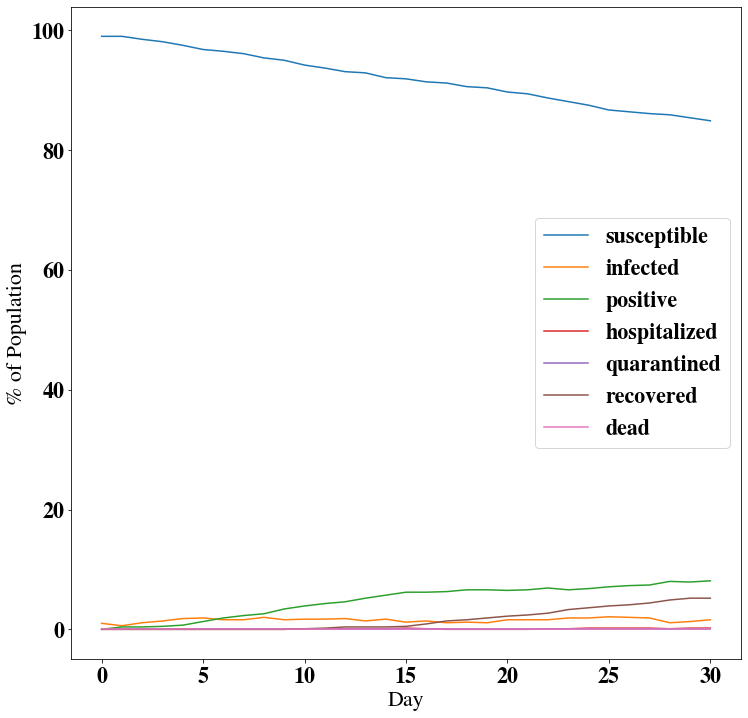

In [151]:
# look at the sird curve (should add "E" at some point)
plt.plot(sird_counts.loc['s', :].T, label = 'susceptible');
#plt.plot(sird_counts.loc['e', :].T, label = 'exposed');
plt.plot(sird_counts.loc['i', :].T, label = 'infected');
#plt.plot(sird_counts.loc['i-as', :].T, label = 'infected-as');
#plt.plot(sird_counts.loc['i-s', :].T, label = 'infected-s');
plt.plot(sird_counts.loc['p', :].T, label = 'positive');
plt.plot(sird_counts.loc['h', :].T, label = 'hospitalized');
plt.plot(sird_counts.loc['q', :].T, label = 'quarantined');
plt.plot(sird_counts.loc['r', :].T, label = 'recovered');
plt.plot(sird_counts.loc['d', :].T, label = 'dead');
plt.legend();
plt.xlabel('Day');
plt.ylabel('% of Population');

In [152]:
sird_counts.iloc[:, -1]

s       84.9
i-as     1.6
i-s      0.0
i        1.6
p        8.1
q        0.0
r        5.2
d        0.0
h        0.2
Name: 30, dtype: float64

## No Mitigation

In [153]:
# Current CFR from COVID from CDC data
CFR = covid_deaths_age_gender['covid_19_deaths'].astype(int).sum() / (covid_cases_age_gender.sum().sum() - covid_deaths_age_gender['covid_19_deaths'].astype(int).sum())
print(CFR)
# want percentage of deaths after simulation to equal CFR

0.04606498012853652


In [156]:
replicates = 200
max_steps = 31

N_t = 3400
#N_t = 1000
N_i = 7 # 34 #33 #0.20 * 0.01 * 5000
#N_i = 10
N_r = 0
#N_r = 47 # assuming 9.3% seroprevalence from lancet paper

#width = 32
#height = 32

width = 40
height = 40

#scenario = scenario_standard

n_cores = 72

In [157]:
states, costs, fps, fns, iqas, tps = MultiProcessorRunCustom(replicates,
                                 max_steps,
                                 N_t, N_i,
                                 N_r, width,
                                 height,
                                 scenario_weekly,
                                 mitigation_strategy_r,
                                 n_cores)

In [110]:
sird_counts = np.ones((replicates, 7, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        
#sird_counts[:, 4, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 6, :] + sird_counts[:, 5, :])

sird_counts = sird_counts * 100 / N_t

In [111]:
with open(os.path.join(out_dir, 'NoMitigation/IOC-5000Agents-200Replicates-SIRD_counts-R0=1.1-02%.pickle'), 'wb') as handle:
     pickle.dump(sird_counts, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [112]:
with open(os.path.join(out_dir,
                           'NoMitigation/IOC-5000Agents-200Replicates-SIRD_counts-R0=1.1-02%.pickle'),
              'rb') as openfile:
        sird_counts = pickle.load(openfile)

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


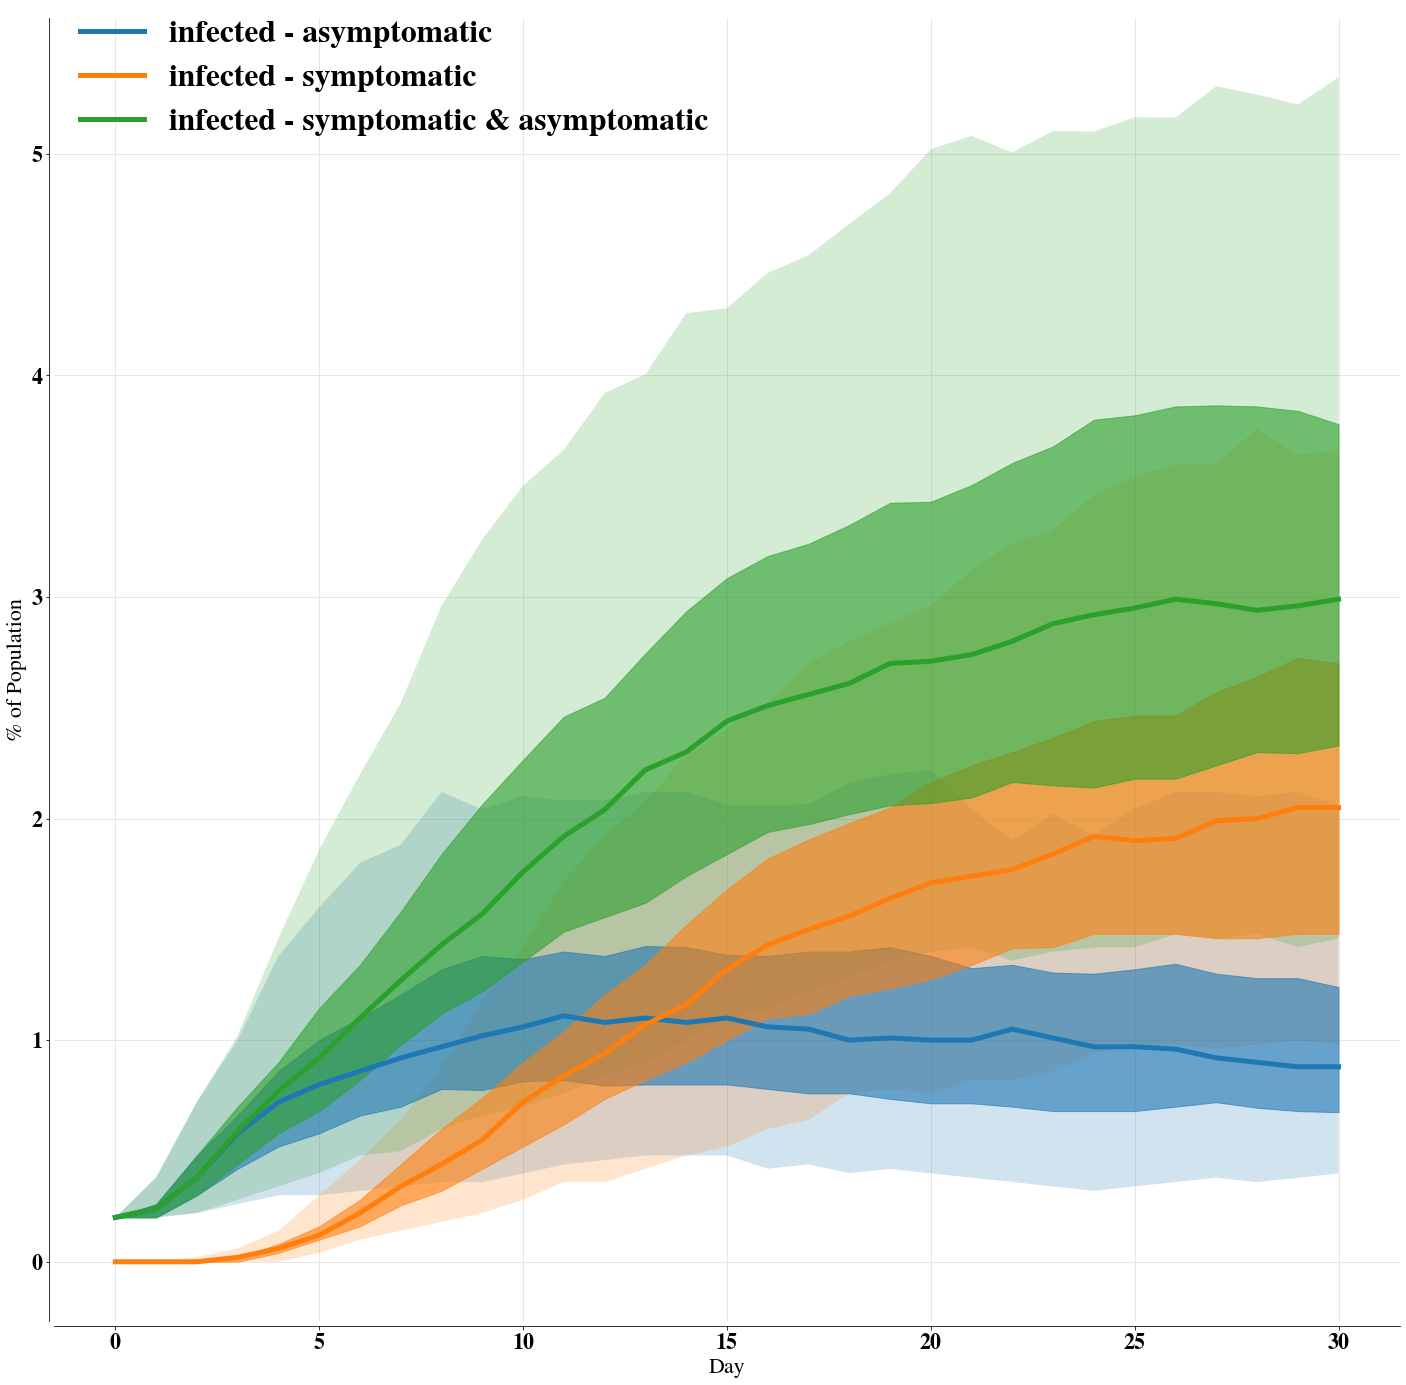

In [113]:
fig = plt.figure(figsize = (20, 20))
ax1 = fig.add_subplot(111)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.tick_params(axis = 'x', direction = 'out')
ax1.tick_params(axis = 'y', direction = 'out')
# offset the spines
for spine in ax1.spines.values():
    spine.set_position(('outward', 5))
# put the grid behind
ax1.set_axisbelow(True)
#ax1.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#ax1.plot(np.median(sird_counts, axis = 0)[3], label = 'infected');
ax1.plot(np.median(sird_counts, axis = 0)[1], lw = 5, label = 'infected - asymptomatic');
ax1.plot(np.median(sird_counts, axis = 0)[2], lw = 5, label = 'infected - symptomatic');

ax1.plot(np.median(sird_counts, axis = 0)[3], lw = 5, label = 'infected - symptomatic & asymptomatic');

#ax1.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
#ax1.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
#ax1.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)

#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)

#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[0],
#                np.percentile(sird_counts, axis = 0, q = 75)[0], alpha = 0.3, color = "C{}".format(0))


ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[1],
                 np.percentile(sird_counts, axis = 0, q = 75)[1], alpha = 0.6, color = "C{}".format(0))

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[2],
                 np.percentile(sird_counts, axis = 0, q = 75)[2], alpha = 0.6, color = "C{}".format(1))

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[3],
                 np.percentile(sird_counts, axis = 0, q = 75)[3], alpha = 0.6, color = "C{}".format(2))


#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[4],
#                 np.percentile(sird_counts, axis = 0, q = 75)[4], alpha = 0.3, color = "C{}".format(4))

#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[5],
#                 np.percentile(sird_counts, axis = 0, q = 75)[5], alpha = 0.3, color = "C{}".format(3))
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[6],
#                 np.percentile(sird_counts, axis = 0, q = 75)[6], alpha = 0.3, color = "C{}".format(4))

ax1.legend(loc = (.01, .9), frameon = False, ncol = 1, fontsize = 'x-large');
ax1.set_xlabel('Day');
ax1.set_ylabel('% of Population');
#ax1.set_title('(A1) Summarized Disease Course', style = 'italic');

#ax1.plot(range(100), np.repeat((100/1.1), 100))
#ax1.plot(np.repeat(np.where(np.median(sird_counts, axis = 0)[3] == np.max(np.median(sird_counts, axis = 0)[3]))[0][0],
#                   100),
#        range(100))

fig.tight_layout();

fig.savefig(os.path.join(fig_dir, 'IOC-R0=1.1-02%-nomitigation.png'), bbox_inches = 'tight')
fig.savefig(os.path.join(fig_dir, 'IOC-R0=1.1-02%-nomitigation.pdf'), dpi = 300, bbox_inches = 'tight')

In [114]:
np.percentile(sird_counts[:, 4, -1], 97.5) - 9.3

3.2219999999999995

In [115]:
np.percentile(sird_counts[:, 4, -1], 50) - 9.3

1.7799999999999994

In [116]:
np.percentile(sird_counts[:, 4, -1], 2.5) - 9.3

0.879999999999999

## Scenarios in Focus: Specific Testing Frequencies/Number of People

In [115]:
mitigation_strategy_r = mitigation(testing_effectiveness, groups = 1, period = 1)

scenario_weekly = scenario_details(comorbidities_distribution = comorbidities_prevalence,
                                     prop_healthy = [0, 0, 0],
                                     spreader_prop = 0.293,
                                     cases_age_gender = covid_cases_age_gender,
                                     risk_death_distribution = (covid_deaths_age_gender,
                                                                covid_deaths_comorbidities),
                                     transmission_probability = np.nan,
                                     mitigation_strategy = mitigation_strategy_r.rt_pcr_random,
                                     external_connectivity = 0.005, #((25000 / 126300000 * 150000) * (2 ** 2) * 0.667) / 150000, # current prevalence in japan times staff-generated infections,
                                     steps_per_day = 1)

In [116]:
replicates = 200
max_steps = 31

N_t = 3400
N_i = 1 # 0.2 * 0.01 * 5000 # int(round(50 * stats.lognorm.sf(x = 11, s = 0.5, loc = 0, scale = np.exp(1.63))))
N_r = 0

# R0 = 1.5
width = 42
height = 43

# R0 = 2
width = 40
height = 40


# R0 = 1.1 but with vaccines
#width = 76
#height = 77

scenario = scenario_weekly

n_cores = 50

In [117]:
states, costs, false_positives, false_negatives, improperly_quarantined_athletes, true_positives = MultiProcessorRunCustom(replicates,
                                        max_steps,
                                        N_t, N_i, N_r,
                                        width, height,
                                        scenario_weekly, mitigation_strategy_r,
                                        n_cores)

In [118]:
sird_counts = np.ones((replicates, 9, max_steps))

for j in tqdm(range(replicates)):
    for i in range(max_steps):
        sird_counts[j, 0, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'susceptible')[0])
        sird_counts[j, 1, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0])
        sird_counts[j, 2, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 3, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-as')[0]) + len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'infected-s')[0])
        sird_counts[j, 5, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'recovered')[0])
        sird_counts[j, 4, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'positive')[0])
        sird_counts[j, 6, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'dead')[0])
        sird_counts[j, 7, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'hospitalized')[0])
        sird_counts[j, 8, i] = len(np.where(np.array([history[i] if len(history) > i else 'recovered' for history in states.state[j]])
                                               == 'quarantine')[0])
        
#sird_counts[:, 5, :] = N_t - (sird_counts[:, 0, :] + sird_counts[:, 1, :] + sird_counts[:, 2, :] + sird_counts[:, 3, :] + sird_counts[:, 4, :] + sird_counts[:, 6, :] + sird_counts[:, 7, :])

sird_counts = sird_counts * 100 / N_t

In [119]:
with open(os.path.join(out_dir,
                       'IOC-beijing-3400Agents-200Replicates-SIRD_counts-R0=2-0.2-testingdaily+2prearrivaltests-99%vaccinated50%effectivevaccines.pickle'), 'wb') as handle:
    pickle.dump((sird_counts, costs, false_positives, false_negatives, improperly_quarantined_athletes, true_positives), handle, protocol = pickle.HIGHEST_PROTOCOL)

In [168]:
with open(os.path.join(out_dir,
                           'IOC-5000Agents-200Replicates-SIRD_counts-R0=1.1-1-proposed-testingdaily+contacttracing+prearrivaltests.pickle'),
              'rb') as openfile:
        sird_counts, costs, fps, fns, iqas, tps = pickle.load(openfile)

In [128]:
sird_counts *= 0.9

'NimbusRoman-Bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


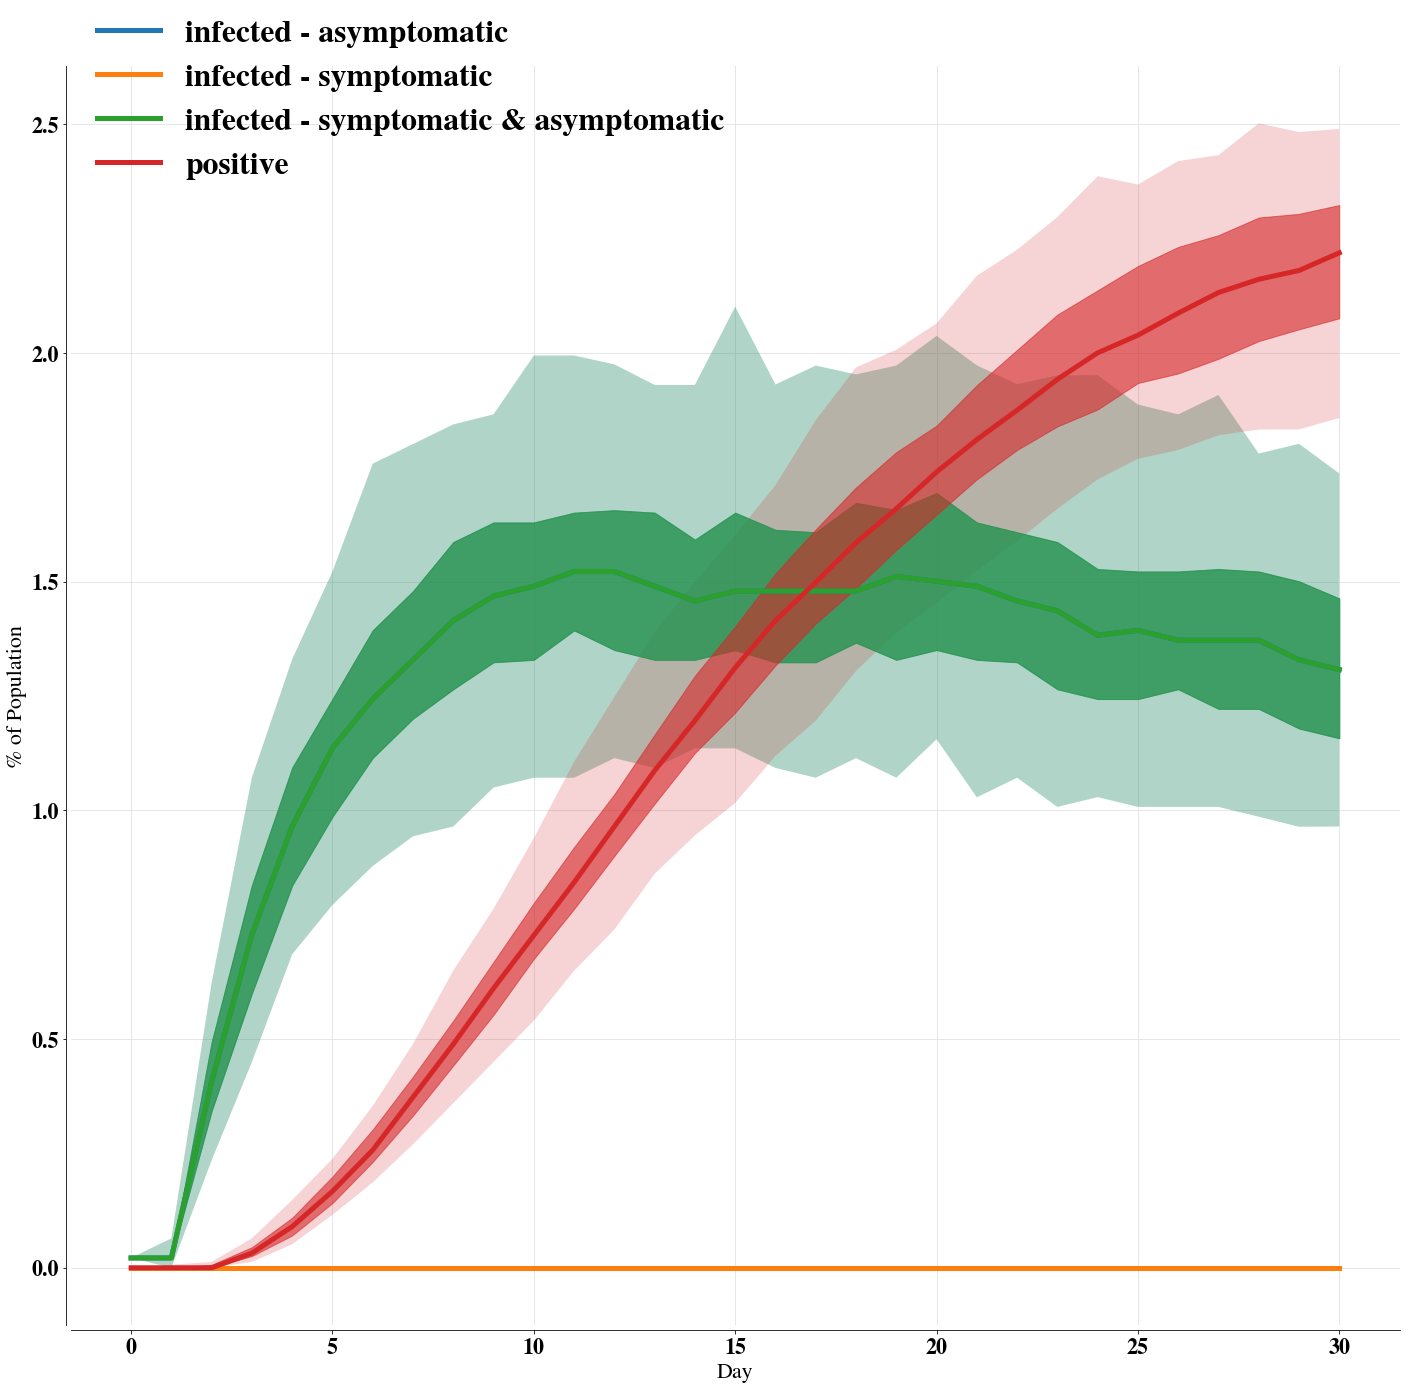

In [129]:
fig = plt.figure(figsize = (20, 20))
ax1 = fig.add_subplot(111)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='both', color="0.9", linestyle='-', linewidth=1)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.tick_params(axis = 'x', direction = 'out')
ax1.tick_params(axis = 'y', direction = 'out')
# offset the spines
for spine in ax1.spines.values():
    spine.set_position(('outward', 5))
# put the grid behind
ax1.set_axisbelow(True)
#ax1.plot(np.median(sird_counts, axis = 0)[0], label = 'susceptible');
#ax1.plot(np.median(sird_counts, axis = 0)[3], label = 'infected');
ax1.plot(np.median(sird_counts, axis = 0)[1], lw = 5, label = 'infected - asymptomatic');
ax1.plot(np.median(sird_counts, axis = 0)[2], lw = 5, label = 'infected - symptomatic');

ax1.plot(np.median(sird_counts, axis = 0)[3], lw = 5, label = 'infected - symptomatic & asymptomatic');
ax1.plot(0.3 * np.median(sird_counts, axis = 0)[4], lw = 5, label = 'positive');

#ax1.plot(np.median(sird_counts, axis = 0)[4], label = 'recovered');
#ax1.plot(np.median(sird_counts, axis = 0)[5], label = 'hospitalized');
#ax1.plot(np.median(sird_counts, axis = 0)[6], label = 'dead');
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[0],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[0], alpha = 0.2)
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[1],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[1], alpha = 0.2)

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[2],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[2], alpha = 0.2)

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[3],
                 np.percentile(sird_counts, axis = 0, q = 97.5)[3], alpha = 0.2)

ax1.fill_between(range(max_steps), 0.3 * np.percentile(sird_counts, axis = 0, q = 2.5)[4],
                 0.3 * np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)

#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[4],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[4], alpha = 0.2)
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[5],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[5], alpha = 0.2)
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 2.5)[6],
#                 np.percentile(sird_counts, axis = 0, q = 97.5)[6], alpha = 0.2)

#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[0],
#                 np.percentile(sird_counts, axis = 0, q = 75)[0], alpha = 0.3, color = "C{}".format(0))


ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[1],
                 np.percentile(sird_counts, axis = 0, q = 75)[1], alpha = 0.6, color = "C{}".format(0))

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[2],
                 np.percentile(sird_counts, axis = 0, q = 75)[2], alpha = 0.6, color = "C{}".format(1))

ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[3],
                 np.percentile(sird_counts, axis = 0, q = 75)[3], alpha = 0.6, color = "C{}".format(2))

ax1.fill_between(range(max_steps), 0.3 * np.percentile(sird_counts, axis = 0, q = 25)[4],
                 0.3 * np.percentile(sird_counts, axis = 0, q = 75)[4], alpha = 0.6, color = "C{}".format(3))


#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[4],
#                 np.percentile(sird_counts, axis = 0, q = 75)[4], alpha = 0.3, color = "C{}".format(4))

#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[5],
#                 np.percentile(sird_counts, axis = 0, q = 75)[5], alpha = 0.3, color = "C{}".format(3))
#ax1.fill_between(range(max_steps), np.percentile(sird_counts, axis = 0, q = 25)[6],
#                 np.percentile(sird_counts, axis = 0, q = 75)[6], alpha = 0.3, color = "C{}".format(4))

ax1.legend(loc = (.01, .9), frameon = False, ncol = 1, fontsize = 'x-large');
ax1.set_xlabel('Day');
ax1.set_ylabel('% of Population');

#ax1.set_xlim([0, 30])

#ax1.set_title('(A1) Summarized Disease Course', style = 'italic');

fig.tight_layout();

fig.savefig(os.path.join(fig_dir, 'IOC-beijing-R0=2-0.2-testingdaily+2prearrivaltests-99%vaccinated50%effectivevaccines.png'), bbox_inches = 'tight')
fig.savefig(os.path.join(fig_dir, 'IOC-beijing-R0=2-0.2-testingdaily+2prearrivaltests-99%vaccinated50%effectivevaccines.pdf'), dpi = 300, bbox_inches = 'tight')

In [130]:
np.percentile(sird_counts[:, 3, -10], q = 2.5)

1.028640441176471

In [131]:
np.percentile(sird_counts[:, 3, -10], q = 50)

1.4901617647058822

In [132]:
np.percentile(sird_counts[:, 3, -10], q = 97.5)

1.9731242647058826

In [118]:
mitigation_strategy_r.cost.running_total

0.0

In [207]:
q = 97.5
100 - 9.3 - np.percentile(sird_counts[:,
                                      0,
                                      -11],
                          q) - sird_counts[np.where(sird_counts[:,
                                                                0,
                                                                -11] == sird_counts[:,
                                                                                    0,
                                                                                    -11].flat[np.abs(sird_counts[:,
                                                                                                                 0,
                                                                                                                 -11] - np.percentile(sird_counts[:,
                                                                                                                                                  0,
                                                                                                                                                  -11],
                                                                                                                                     q)).argmin()])[0][0], 4, -11]

2.078500000000002

In [366]:
100 - 9.3 - np.percentile(sird_counts[:, 0, -11], q = 50)

30.240000000000002

In [209]:
100 - 9.3 - np.percentile(sird_counts[:, 0, -11], q = 2.5)

10.445499999999996

In [210]:
100 - 9.3 - np.percentile(sird_counts[:, 0, -11], q = 97.5)

6.098500000000001

In [169]:
np.percentile(sird_counts[:, 8, -11], q = 2.5)

IndexError: index 8 is out of bounds for axis 1 with size 7

In [211]:
(np.percentile(costs, 50) / 5000) / 120

6.6203

In [194]:
np.percentile(false_positives, 50) * 40000 / 5000

13368.0

In [315]:
q = 50
120 * ((np.percentile(true_positives,
                      q) * 40000 / (1 * 5000)) + (.9 * 18000 * 0.02 * 5)) + (np.sum(((5000 / (34 * 35)) - 1) * 120 * np.abs(np.percentile(np.diff(sird_counts[:, 3, :],
                             axis = 1),
                     axis = 1,
                     q = 50)) * 5000 / 100) * (40000 / 5000))

1463148.907563025

In [316]:
120 * np.percentile(true_positives, 50) * 40000 / 5000

146880.0

In [323]:
np.sum(40000 * 120 * 2.1 * np.percentile(sird_counts[:, 3, :], axis = 0, q = 50))

766584000.0

In [112]:
np.sum(120 * -np.percentile(np.diff(sird_counts[:, 3, :],
                             axis = 1),
                     axis = 1,
                     q = 50) * 5000 / 100) * (18000 / 5000) + (0.02 * 10 * 18000 * 120)

432216.0

In [113]:
np.sum(120 * -np.percentile(np.diff(sird_counts[:, 3, :],
                             axis = 1),
                     axis = 1,
                     q = 97.5) * 5000 / 100) * (18000 / 5000) + (0.02 * 6 * 18000 * 120) + np.sum(((5000 / (34 * 35)) - 1) * 120 * -np.percentile(np.diff(sird_counts[:, 3, :],
                             axis = 1),
                     axis = 1,
                     q = 97.5) * 18000 / 100)

-7093875.630252089

In [202]:
(np.percentile([np.unique(improperly_quarantined_athletes[i]).shape[0] for i in range(200)], 50) / 5000)

0.2648

In [201]:
0.4 * 40000

16000.0

In [200]:
np.percentile(false_negatives, 50) * 40000 / (5000)

500.0